In [1]:
# Imports we will use
import torch
import gc
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Function
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import random
from pathlib import Path
from sklearn.metrics import r2_score
from astropy.visualization import make_lupton_rgb
from sklearn.manifold import Isomap
from train_utils import *
import time
import os
import json

%matplotlib inline
plt.rcParams.update({'font.size': 12})

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Set Seed
torch.manual_seed(22)

# Find if cuda is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [2]:
# Load in data
head = Path.cwd().parents[3]
source_img_path = head / 'data/mb_lenscolor_source/mb_lenscolor_source.npy'
target_img_path = head / 'data/mb_lenscolor_target/mb_lenscolor_target.npy'
source_meta = head / 'data/mb_lenscolor_source/mb_lenscolor_source_metadata.csv'
target_meta = head / 'data/mb_lenscolor_target/mb_lenscolor_target_metadata.csv'
batch_size = 32
source_train_dataloader, source_test_dataloader, source_val_dataloader, source_data = create_dataloader(source_img_path, source_meta, batch_size)
target_train_dataloader, target_test_dataloader, target_val_dataloader, target_data = create_dataloader(target_img_path, target_meta, batch_size)

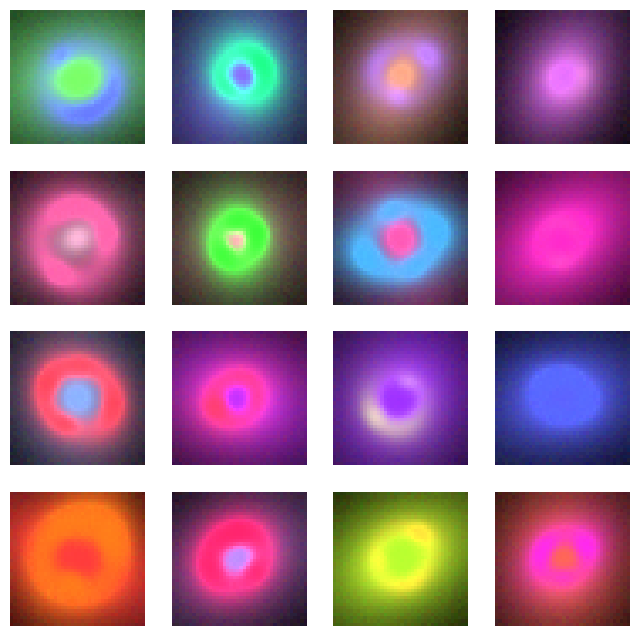

In [3]:
# Visualize source data
visualize_data(source_data)

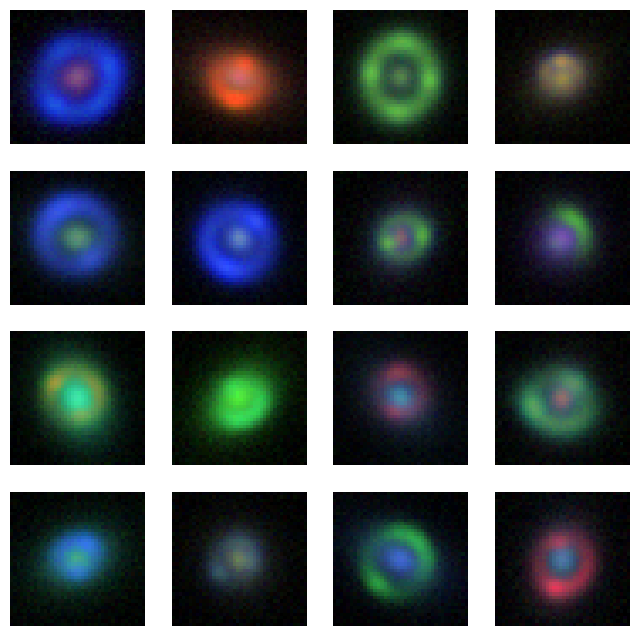

In [4]:
# Visualize target data
visualize_data(target_data)

In [5]:
# Define and initialize model
class NeuralNetwork(nn.Module):
    def __init__(self, npix):
        super(NeuralNetwork, self).__init__()
        self.feature = nn.Sequential()
        self.feature.add_module('f_conv1', nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding='same'))
        self.feature.add_module('f_relu1', nn.ReLU(True))
        self.feature.add_module('f_bn1', nn.BatchNorm2d(8))
        self.feature.add_module('f_pool1', nn.MaxPool2d(kernel_size=2, stride=2))
        self.feature.add_module('f_conv2', nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding='same'))
        self.feature.add_module('f_relu2', nn.ReLU(True))
        self.feature.add_module('f_bn2', nn.BatchNorm2d(16))
        self.feature.add_module('f_pool2', nn.MaxPool2d(kernel_size=2, stride=2))
        self.feature.add_module('f_conv3', nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding='same'))
        self.feature.add_module('f_relu3', nn.ReLU(True))
        self.feature.add_module('f_bn3', nn.BatchNorm2d(32))
        self.feature.add_module('f_pool3', nn.MaxPool2d(kernel_size=2, stride=2))

        self.regressor = nn.Sequential()
        self.regressor.add_module('r_fc1', nn.Linear(in_features=32*5*5, out_features=128))
        self.regressor.add_module('r_relu1', nn.ReLU(True))
        self.regressor.add_module('r_fc3', nn.Linear(in_features=128, out_features=2))

        self.npix = npix

    def forward(self, x):
        x = x.view(-1, 3, self.npix, self.npix)

        features = self.feature(x)
        features = features.view(-1, 32*5*5)
        estimate = self.regressor(features)
        estimate = F.relu(estimate)
        estimate = estimate.view(-1, 2)

        return estimate, features


    def get_feature(self, x):
        x = x.view(-1, 3, self.npix, self.npix)
        features = self.feature(x)
        features = features.view(-1, 32*5*5)
        return features

In [6]:
def loss_bnll(mean, variance, truth, beta, epsilon = 1e-7):  # beta=0.5):
    """Compute beta-NLL loss

    :param mean: Predicted mean of shape B x D
    :param variance: Predicted variance of shape B x D
    :param truth: truth of shape B x D
    :param beta: Parameter from range [0, 1] controlling relative
        weighting between data points, where `0` corresponds to
        high weight on low error points and `1` to an equal weighting.
    :returns: Loss per batch element of shape B
    """
    variance = variance + epsilon
    loss = 0.5 * ((truth - mean) ** 2 / variance + variance.log())
    if beta > 0:
        loss = loss * (variance.detach() ** beta)
    return loss.sum(axis=-1) / len(mean)

In [7]:
# Define training loop
def train_loop(source_dataloader, 
               target_dataloader, 
               model, 
               regressor_loss_fn,
               da_loss,
               optimizer,
               n_epoch,
               epoch,
               init_wt_da,
               final_wt_da,
               beta_init,
               beta_final):
               # init_wt_mve,
               # final_wt_mve):
    """
    Trains the Neural Network on Source/Target Domains with the following loss:
        Loss = Source Regression Loss + 1.4 * DA MMD Loss
    
    source_dataloader: DataLoader for the source domain data.
	target_dataloader: DataLoader for the target domain data.
	model: The neural network model to be trained.
	regressor_loss_fn: Loss function for the regression task (e.g., MSELoss).
	da_loss: Loss function for domain adaptation (e.g., MMD loss).
	optimizer: Optimizer for the model parameters.
	n_epoch: Total number of epochs for training.
	epoch: Current epoch number.
    """

    domain_error = 0
    domain_classifier_accuracy = 0
    estimator_error = 0
    mve_error = 0
    score_list = np.array([])

    # Iteration length is shorter of the two datasets
    len_dataloader = min(len(source_dataloader), len(target_dataloader))
    data_source_iter = iter(source_dataloader)
    data_target_iter = iter(target_dataloader)

    # Iterate over the two datasets
    i = 0
    while i < len_dataloader:

        # Time-varying hyperparameter, p 0 -> infty, alpha 0 -> 1
        p = float(i + epoch * len_dataloader) / n_epoch / len_dataloader # UNUSED
        alpha = 2. / (1. + np.exp(-10 * p)) - 1 # UNUSED

        # Source Training

        # Load a batch of source data, move to GPU
        data_source = next(data_source_iter)
        X, y = data_source
        X = X.float()
        X = X.cuda()
        y = y.cuda()

        # Zero model gradients and labels
        model.zero_grad()
        batch_size = len(y)

        domain_label = torch.zeros(batch_size)
        domain_label = domain_label.long()
        domain_label = domain_label.cuda()

        # Apply data to model and get predictions, embeddings, apply gradients
        estimate_output, domain_output_source = model(X)
        mean = estimate_output[:, 0]
        variance = estimate_output[:, 1]

        # print(y.shape)
        # print(mean.shape)
        # Calculate source regression loss based on predictions
        estimate_loss = regressor_loss_fn(mean, y)

        
        # Target Training

        data_target = next(data_target_iter)
        X_target, _ = data_target
        X_target = X_target.float()
        X_target = X_target.cuda()

        batch_size = len(X_target)

        _, domain_output_target = model(X_target)

        # Calculate the DA Loss between source and target, MMD loss
        domain_loss = da_loss(domain_output_source, domain_output_target)
        beta_val = beta_init - (beta_init - beta_final) * (2 * epoch / n_epoch)

        if ((epoch / n_epoch) > 0.5):
            beta_val = beta_final

        
        mve_loss = loss_bnll(mean.flatten(), variance.flatten(), y, beta = beta_val)
        
        # Hyperparameter of da_weight set to weight domain loss vs source loss
        # Perhaps this is where alpha was initially used
        da_weight = init_wt_da - ((init_wt_da - final_wt_da) * (epoch / n_epoch))
        # mve_weight_power = (init_wt_mve - ((init_wt_mve - final_wt_mve) * (epoch / n_epoch)))
        # mve_weight = 10 ** (-mve_weight_power)

        # Calculate the R2 score of the predictions vs. labels
        score = r2_score(y.cpu().detach().numpy(), mean.cpu().detach().numpy())

        loss = mve_loss + domain_loss * da_weight 

        
        
        # Backpropagation, update optimizer lr
        loss.backward()
        optimizer.step()

        # Update values
        
        # Domain loss is the DA loss or MMD loss between embedding outputs
        domain_error += domain_loss.item()

        # Estimator loss is the source data loss on regression
        estimator_error += estimate_loss.item()

        mve_error += mve_loss.item()

        score_list = np.append(score_list, score)

        i += 1

    # Calculate average scores/errors of batches for this epoch
    score = np.mean(score_list)
    domain_error = domain_error / (len_dataloader)
    estimator_error /= len_dataloader
    mve_error /= len_dataloader

    return [domain_error, estimator_error, mve_error, score]

In [8]:
def test_loop(source_dataloader, 
              target_dataloader, 
              model, 
              regressor_loss_fn, 
              da_loss, 
              n_epoch, 
              epoch,
              beta_init,
              beta_final):
    """
    Tests the model accuracy.
    
    source_dataloader: DataLoader for the source domain data.
	target_dataloader: DataLoader for the target domain data.
	model: The neural network model to be trained.
	regressor_loss_fn: Loss function for the regression task (e.g., MSELoss).
	da_loss: Loss function for domain adaptation (e.g., MMD loss). UNUSED
	n_epoch: Total number of epochs for training.
	epoch: Current epoch number.
    """

    
    # Evaluating without gradient computation in bg for validation
    with torch.no_grad():
        
        len_dataloader = min(len(source_dataloader), len(target_dataloader))
        data_source_iter = iter(source_dataloader)
        data_target_iter = iter(target_dataloader)

        
        domain_classifier_error = 0
        domain_classifier_accuracy = 0
        estimator_error = 0
        estimator_error_target = 0
        mve_error = 0
        mve_error_target = 0
        score_list = np.array([])
        score_list_target = np.array([])

        i = 0
        while i < len_dataloader:

            p = float(i + epoch * len_dataloader) / n_epoch / len_dataloader
            alpha = 2. / (1. + np.exp(-10 * p)) - 1

            # Source Testing

            data_source = next(data_source_iter)
            X, y = data_source
            X = X.float()
            X = X.cuda()
            y = y.cuda()

            batch_size = len(y)

            estimate_output, domain_output = model(X)
            source_mean = estimate_output[:, 0]
            source_variance = estimate_output[:, 1]
            beta_val = beta_init - (beta_init - beta_final) * (2 * epoch / n_epoch)

            if ((epoch / n_epoch) > 0.5):
                beta_val = beta_final
            
            estimate_loss = regressor_loss_fn(source_mean, y)
            mve_loss = loss_bnll(source_mean.flatten(), source_variance.flatten(), y, beta = beta_val)

            # Target Testing

            data_target = next(data_target_iter)
            X_target, y_target = data_target
            X_target = X_target.float()
            X_target = X_target.cuda()
            y_target = y_target.cuda()

            batch_size = len(X_target)

            estimate_output_target, domain_output = model(X_target)
            target_mean = estimate_output_target[:, 0]
            target_variance = estimate_output_target[:, 1]
            
            estimate_loss_target = regressor_loss_fn(target_mean, y_target)
            mve_loss_target = loss_bnll(target_mean.flatten(), target_variance.flatten(), y_target, beta = beta_val)
            
            # Update values

            # Regression loss on validation testing
            estimator_error += estimate_loss.item()
            estimator_error_target += estimate_loss_target.item()

            # MVE loss on validation testing
            mve_error += mve_loss.item()
            mve_error_target += mve_loss_target.item()

            # R2 Scores on validation testing
            score = r2_score(y.cpu(), source_mean.cpu())
            score_list = np.append(score_list, score)
            score_target = r2_score(y_target.cpu(), target_mean.cpu())
            score_list_target = np.append(score_list_target, score_target)

            i += 1

        score = np.mean(score_list)
        score_target = np.mean(score_list_target)
        estimator_error /= len_dataloader
        estimator_error_target /= len_dataloader
        mve_error /= len_dataloader
        mve_error_target /= len_dataloader
        
    classifier_error = 1 # UNUSED, legacy
    return [classifier_error, estimator_error, estimator_error_target, score, score_target, mve_error, mve_error_target]

In [9]:
model = NeuralNetwork(npix=40).cuda()
learning_rate = 2e-5
epochs = 75
# Define loss functions and optimizer
regressor_loss_fn = nn.MSELoss().cuda()

# Try to adjust momentum -> see if that helps
# Try SGD, Adadelta, see if that helps
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
da_loss = MMD_loss()

source_labels = pd.read_csv(source_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]
target_labels = pd.read_csv(target_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]

In [10]:
mod_name = None#"models/mb_lenscolor_jul25_1700" #
stats = {'train_DA_loss':[],
             'train_regression_loss':[],
             'train_mve_loss':[],
             'train_r2_score':[],
             'val_source_regression_loss':[],
             'val_target_regression_loss':[],
             'val_source_r2_score':[],
             'val_target_r2_score':[],
             'val_source_mve_loss': [],
             'val_target_mve_loss': [],
            'epoch_no': 0}
if mod_name is not None:
    state = torch.load(mod_name)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    
    stat_file = Path(mod_name+'.json')
    if stat_file.is_file():
        stats = json.load(open(mod_name+'.json', 'r'))

Beginning Training...
Generating Isomap...


/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


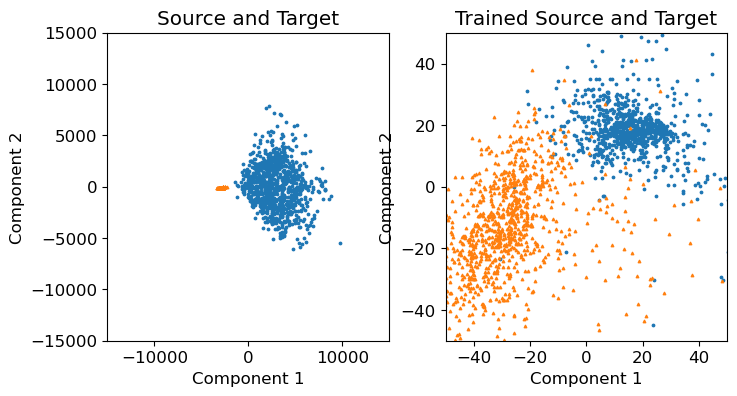

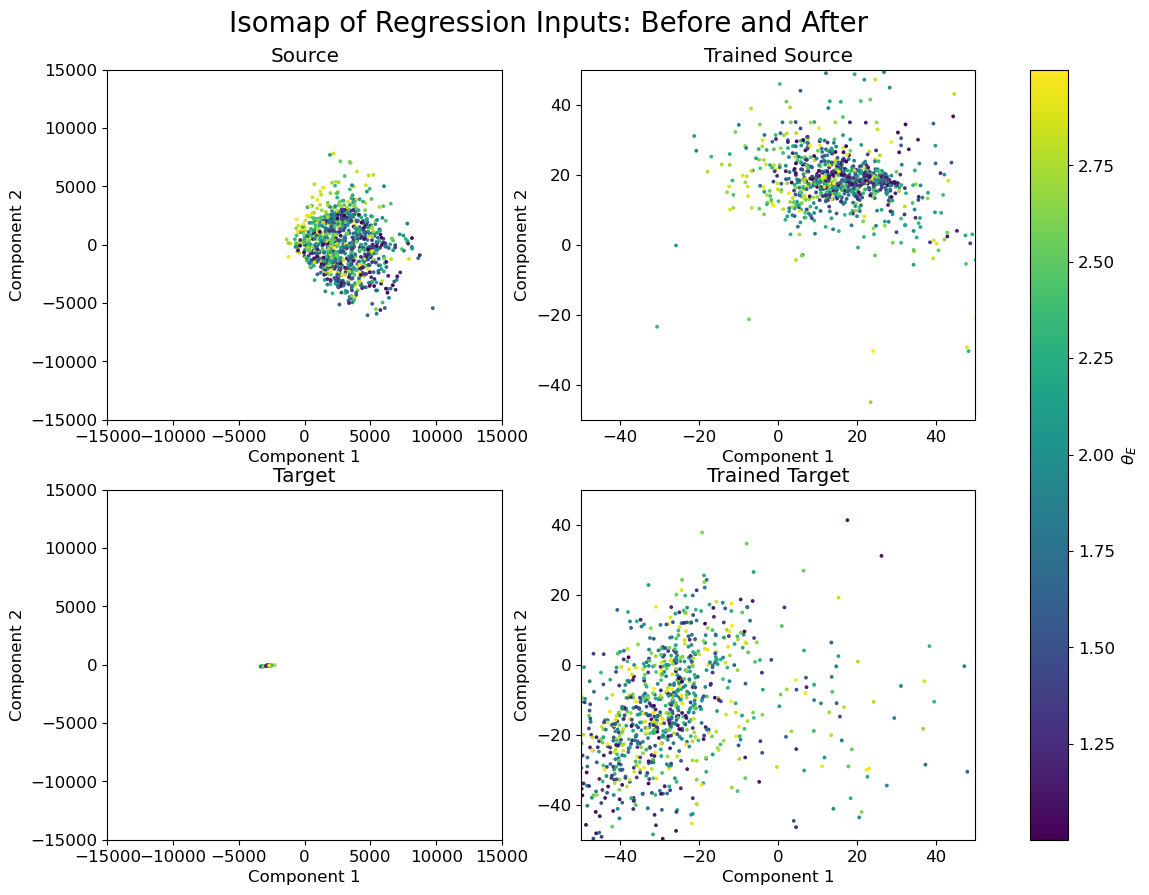


Epoch 0: 13.13s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3768
	Train Regression Loss: : 0.9861
	Train Mve Loss: : 0.4409
	Train R2 Score: : -2.1080
 Validation Statistics:
	Val Source Regression Loss: : 0.1728
	Val Target Regression Loss: : 0.2012
	Val Source R2 Score: : 0.4586
	Val Target R2 Score: : 0.3614
	Val Source Mve Loss: : -0.0633
	Val Target Mve Loss: : -0.0456
Saving Model... Done.
Saving Model MVE... Done.

Epoch 1: 14.83s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2212
	Train Regression Loss: : 0.1078
	Train Mve Loss: : -0.0847
	Train R2 Score: : 0.6610
 Validation Statistics:
	Val Source Regression Loss: : 0.0792
	Val Target Regression Loss: : 0.1038
	Val Source R2 Score: : 0.7474
	Val Target R2 Score: : 0.6716
	Val Source Mve Loss: : -0.0969
	Val Target Mve Loss: : -0.0830
Saving Model... Done.
Saving Model MVE... Done.

Epoch 2: 13.45s
-------------------------------
 Training Statistics:
	Train Da Loss: :

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


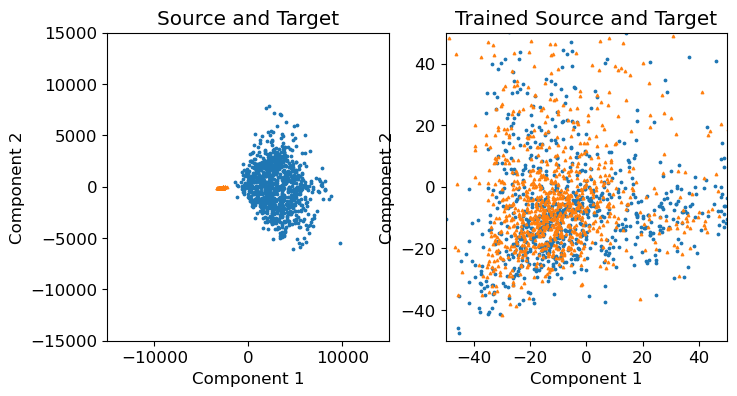

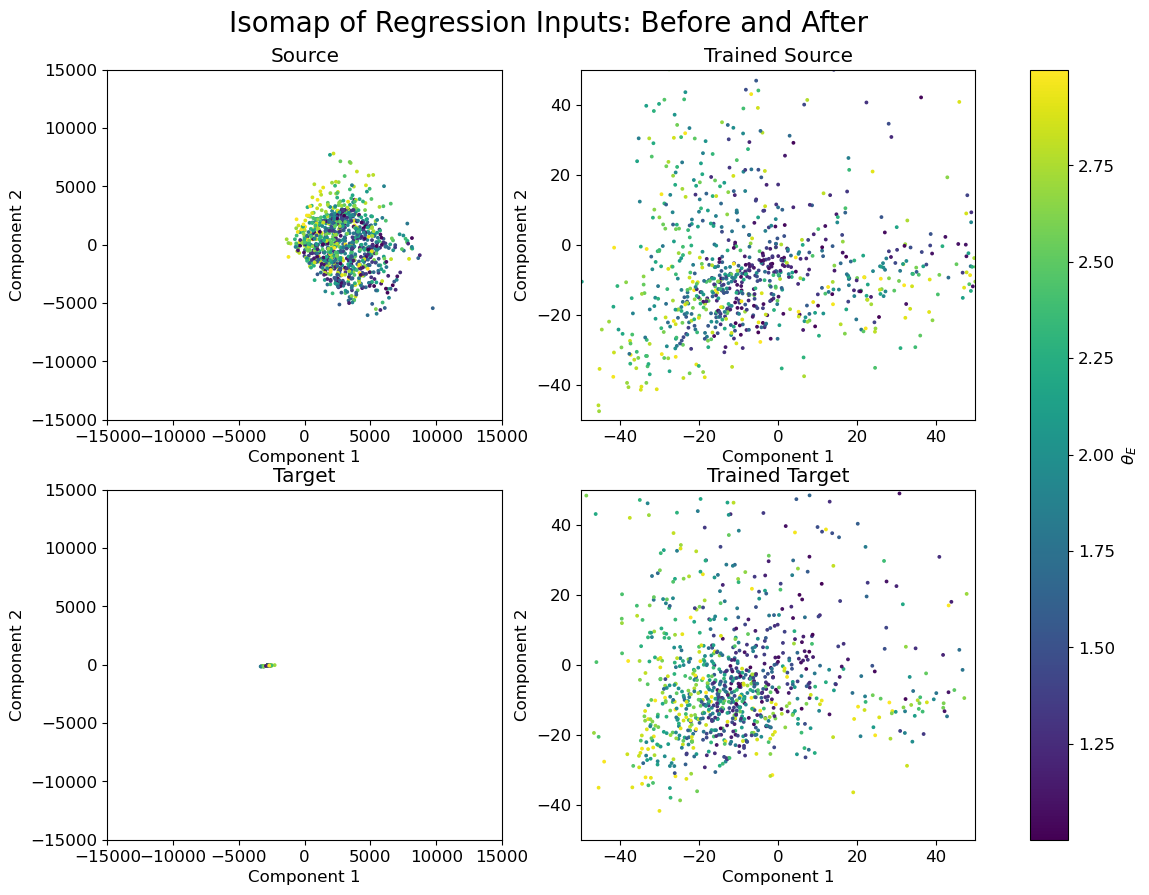

Saving Model... Done.
Saving Model MVE... Done.

Epoch 5: 12.37s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1591
	Train Regression Loss: : 0.0431
	Train Mve Loss: : -0.0846
	Train R2 Score: : 0.8646
 Validation Statistics:
	Val Source Regression Loss: : 0.0450
	Val Target Regression Loss: : 0.0529
	Val Source R2 Score: : 0.8603
	Val Target R2 Score: : 0.8337
	Val Source Mve Loss: : -0.1254
	Val Target Mve Loss: : -0.1149
Saving Model... Done.
Saving Model MVE... Done.

Epoch 6: 13.46s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1558
	Train Regression Loss: : 0.0392
	Train Mve Loss: : -0.0912
	Train R2 Score: : 0.8770
 Validation Statistics:
	Val Source Regression Loss: : 0.0413
	Val Target Regression Loss: : 0.0485
	Val Source R2 Score: : 0.8692
	Val Target R2 Score: : 0.8470
	Val Source Mve Loss: : -0.0859
	Val Target Mve Loss: : -0.0724
Saving Model... Done.
Saving Model MVE... Done.

Epoch 7: 12.40s
-----------------------

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


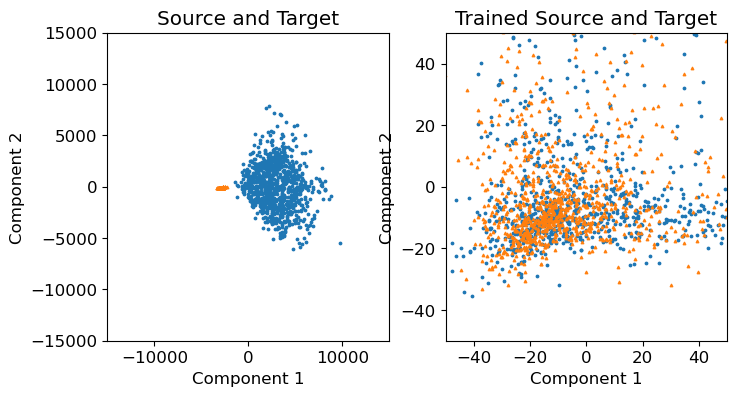

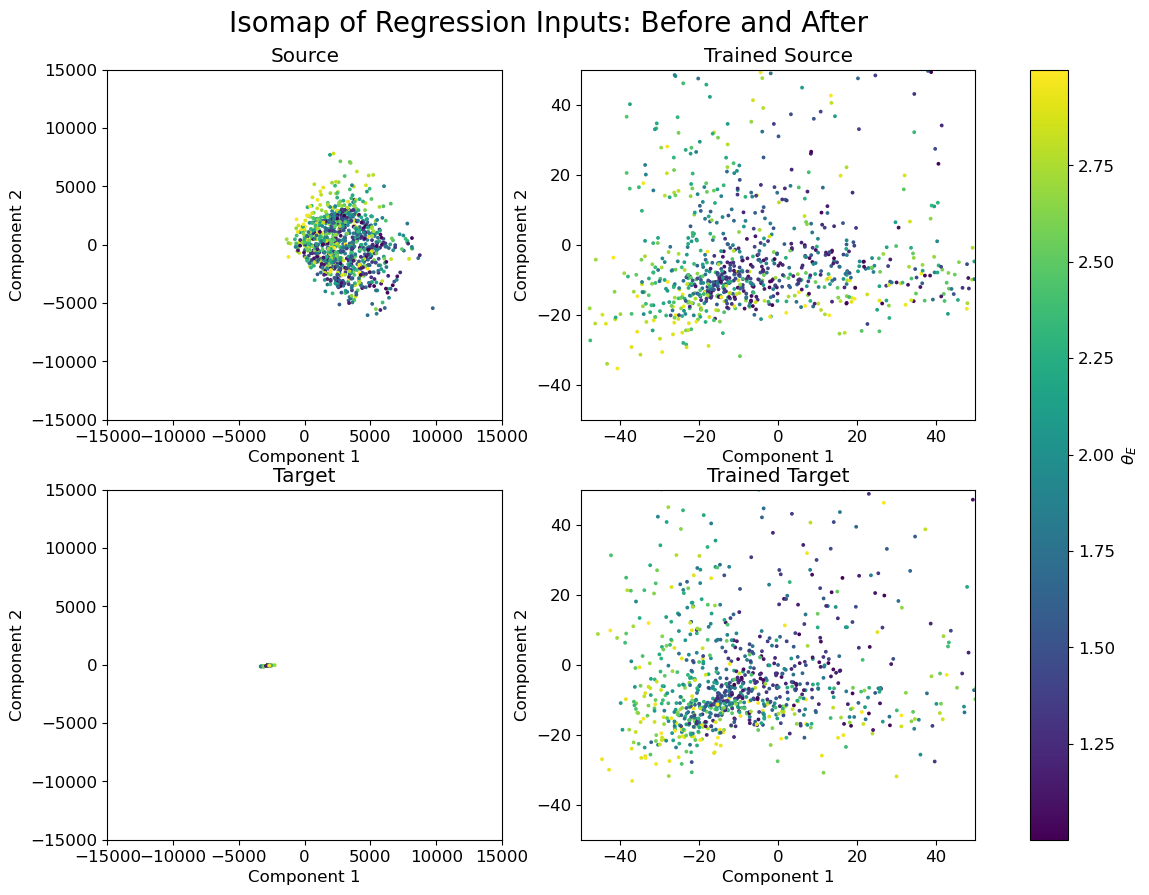

Saving Model... Done.
Saving Model MVE... Done.

Epoch 10: 14.47s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1473
	Train Regression Loss: : 0.0315
	Train Mve Loss: : -0.1112
	Train R2 Score: : 0.9008
 Validation Statistics:
	Val Source Regression Loss: : 0.0345
	Val Target Regression Loss: : 0.0373
	Val Source R2 Score: : 0.8934
	Val Target R2 Score: : 0.8816
	Val Source Mve Loss: : -0.0675
	Val Target Mve Loss: : -0.0515
Saving Model... Done.
Saving Model MVE... Done.

Epoch 11: 12.35s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1461
	Train Regression Loss: : 0.0297
	Train Mve Loss: : -0.0522
	Train R2 Score: : 0.9069
 Validation Statistics:
	Val Source Regression Loss: : 0.0311
	Val Target Regression Loss: : 0.0347
	Val Source R2 Score: : 0.9025
	Val Target R2 Score: : 0.8916
	Val Source Mve Loss: : 0.0030
	Val Target Mve Loss: : 0.0328
Saving Model... Done.
Saving Model MVE... Done.

Epoch 12: 12.82s
----------------------

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


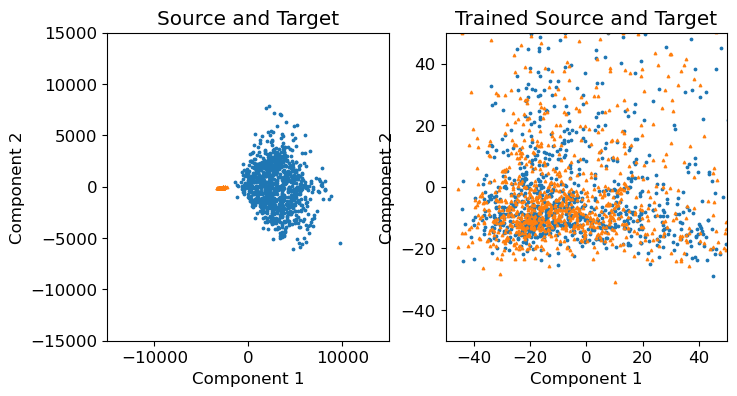

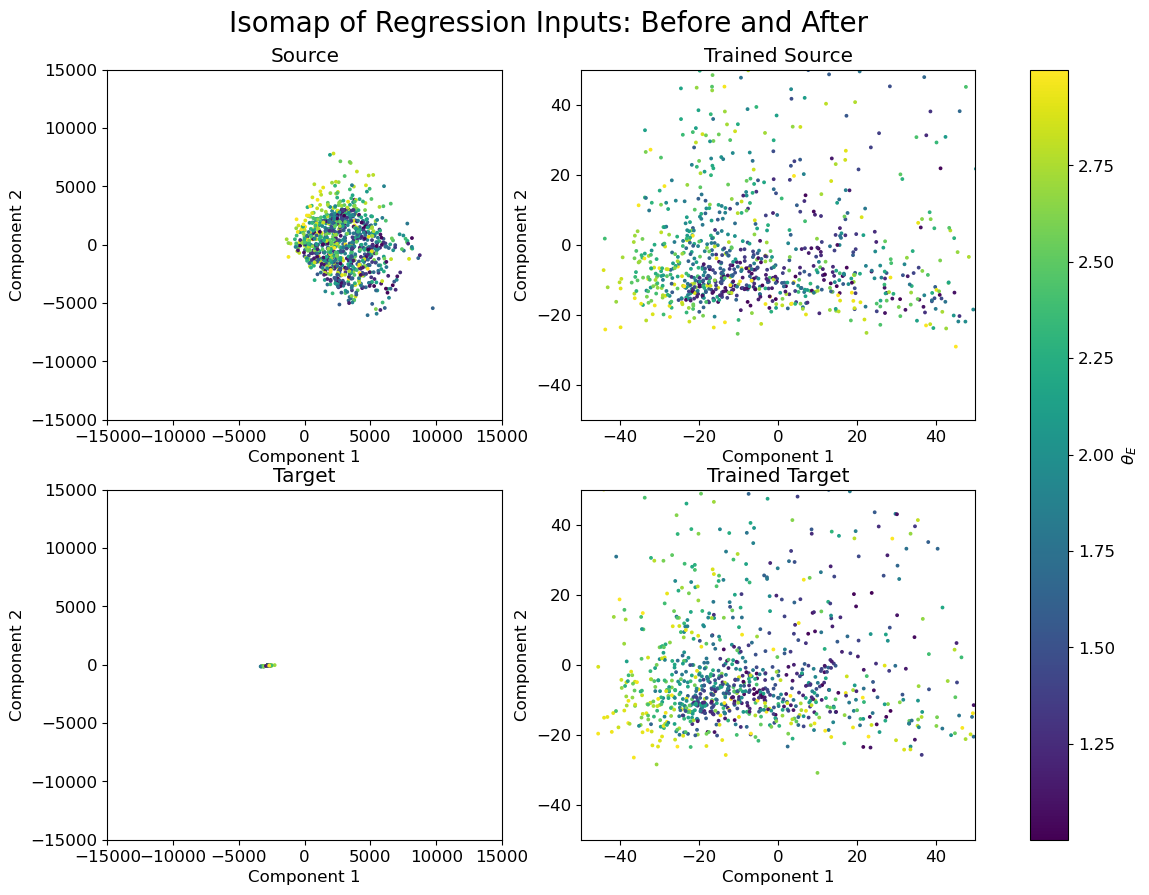

Saving Model... Done.
Saving Model MVE... Done.

Epoch 15: 11.96s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1442
	Train Regression Loss: : 0.0247
	Train Mve Loss: : -0.0825
	Train R2 Score: : 0.9223
 Validation Statistics:
	Val Source Regression Loss: : 0.0279
	Val Target Regression Loss: : 0.0311
	Val Source R2 Score: : 0.9117
	Val Target R2 Score: : 0.9012
	Val Source Mve Loss: : -0.1562
	Val Target Mve Loss: : -0.1581
Saving Model... Done.
Saving Model MVE... Done.

Epoch 16: 12.58s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1413
	Train Regression Loss: : 0.0244
	Train Mve Loss: : -0.0853
	Train R2 Score: : 0.9236
 Validation Statistics:
	Val Source Regression Loss: : 0.0265
	Val Target Regression Loss: : 0.0291
	Val Source R2 Score: : 0.9181
	Val Target R2 Score: : 0.9075
	Val Source Mve Loss: : -0.1506
	Val Target Mve Loss: : -0.1508
Saving Model... Done.
Saving Model MVE... Done.

Epoch 17: 12.46s
--------------------

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


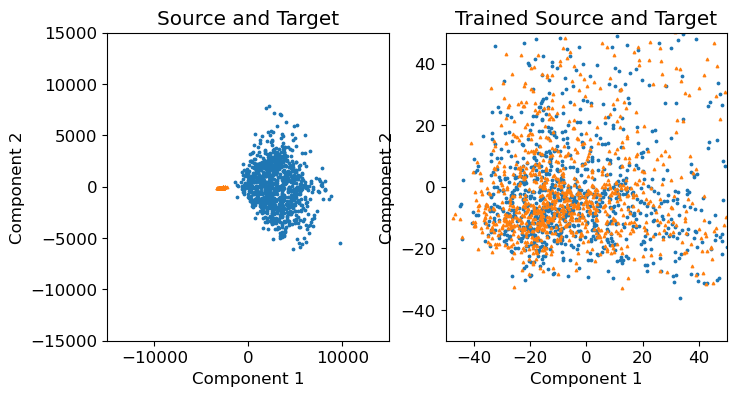

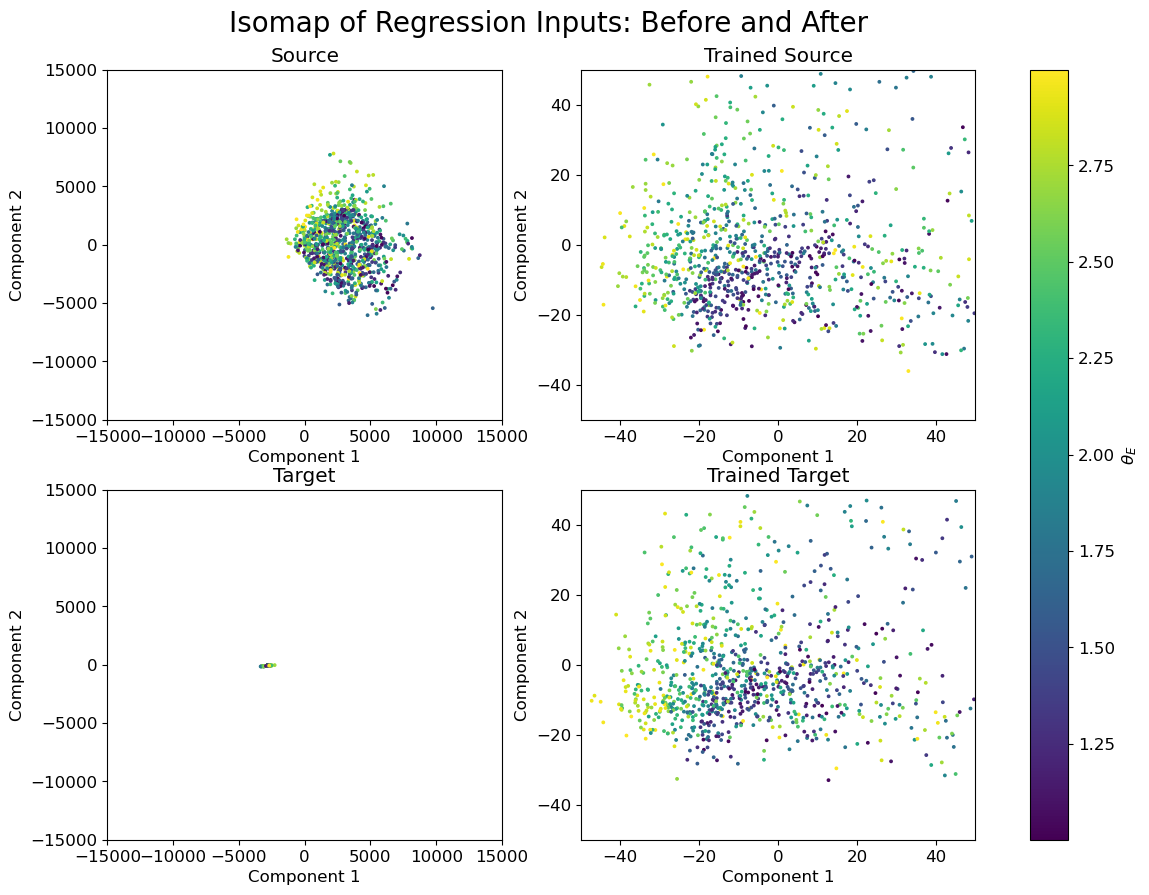

Saving Model... Done.
Saving Model MVE... Done.

Epoch 20: 11.93s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1381
	Train Regression Loss: : 0.0225
	Train Mve Loss: : -0.0390
	Train R2 Score: : 0.9293
 Validation Statistics:
	Val Source Regression Loss: : 0.0238
	Val Target Regression Loss: : 0.0264
	Val Source R2 Score: : 0.9249
	Val Target R2 Score: : 0.9159
	Val Source Mve Loss: : 0.8865
	Val Target Mve Loss: : 1.0788
Saving Model... Done.

Epoch 21: 15.01s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1385
	Train Regression Loss: : 0.0228
	Train Mve Loss: : -0.0489
	Train R2 Score: : 0.9284
 Validation Statistics:
	Val Source Regression Loss: : 0.0257
	Val Target Regression Loss: : 0.0294
	Val Source R2 Score: : 0.9193
	Val Target R2 Score: : 0.9069
	Val Source Mve Loss: : 0.0983
	Val Target Mve Loss: : 0.1401
Saving Model MVE... Done.

Epoch 22: 13.95s
-------------------------------
 Training Statistics:
	Train Da Loss: : 

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


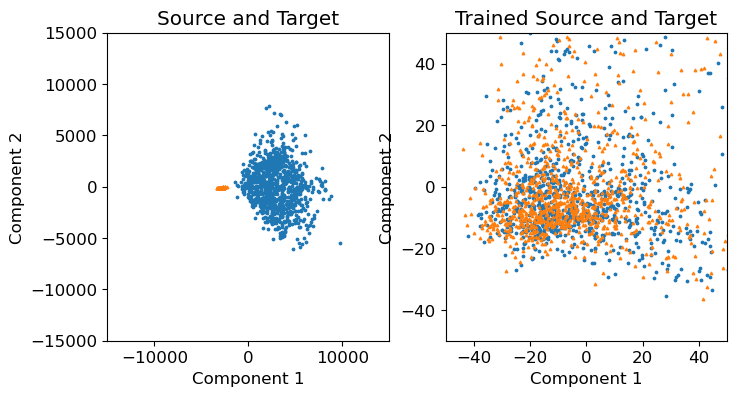

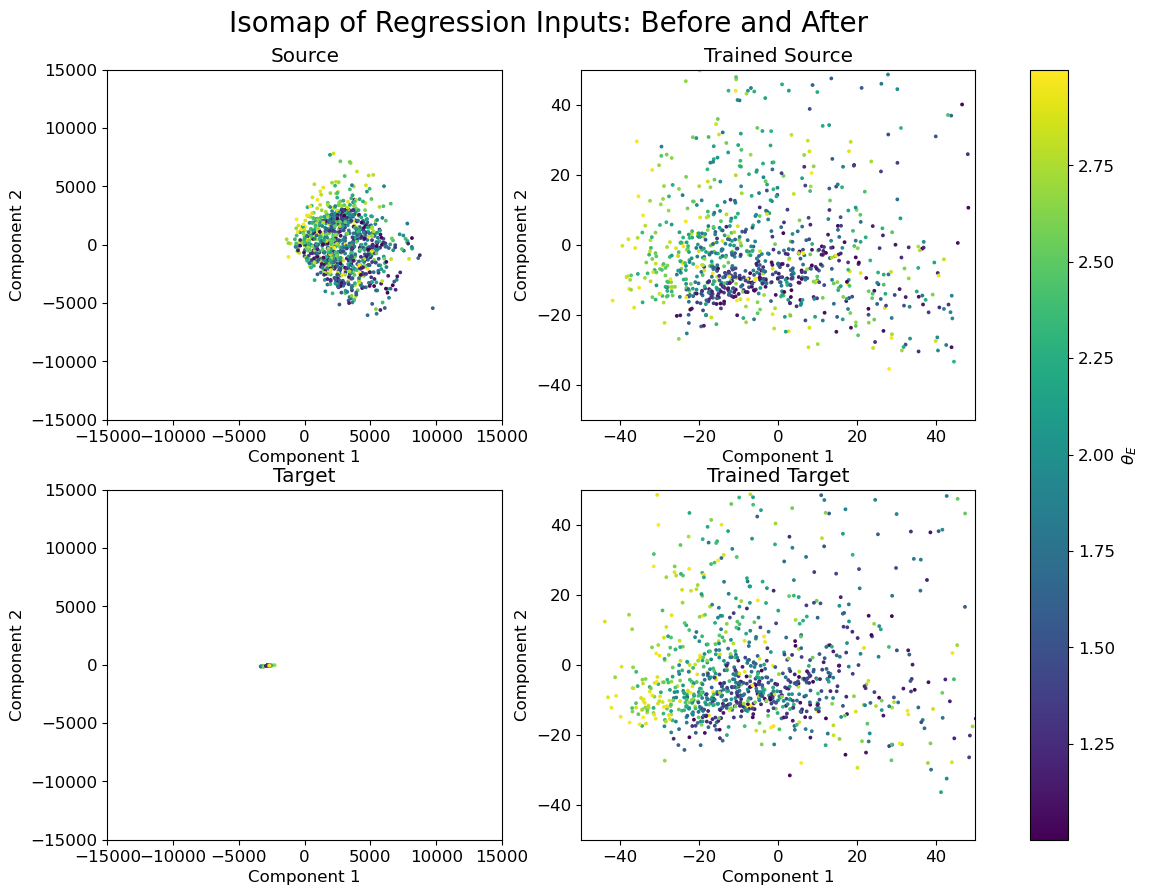

Saving Model MVE... Done.

Epoch 25: 15.08s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1368
	Train Regression Loss: : 0.0201
	Train Mve Loss: : -0.0983
	Train R2 Score: : 0.9369
 Validation Statistics:
	Val Source Regression Loss: : 0.0225
	Val Target Regression Loss: : 0.0261
	Val Source R2 Score: : 0.9296
	Val Target R2 Score: : 0.9169
	Val Source Mve Loss: : -0.0687
	Val Target Mve Loss: : -0.0097
Saving Model... Done.
Saving Model MVE... Done.

Epoch 26: 14.61s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1365
	Train Regression Loss: : 0.0211
	Train Mve Loss: : -0.0916
	Train R2 Score: : 0.9337
 Validation Statistics:
	Val Source Regression Loss: : 0.0226
	Val Target Regression Loss: : 0.0263
	Val Source R2 Score: : 0.9291
	Val Target R2 Score: : 0.9159
	Val Source Mve Loss: : 0.4649
	Val Target Mve Loss: : 0.9108
Saving Model MVE... Done.

Epoch 27: 14.68s
-------------------------------
 Training Statistics:
	Train Da Lo

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


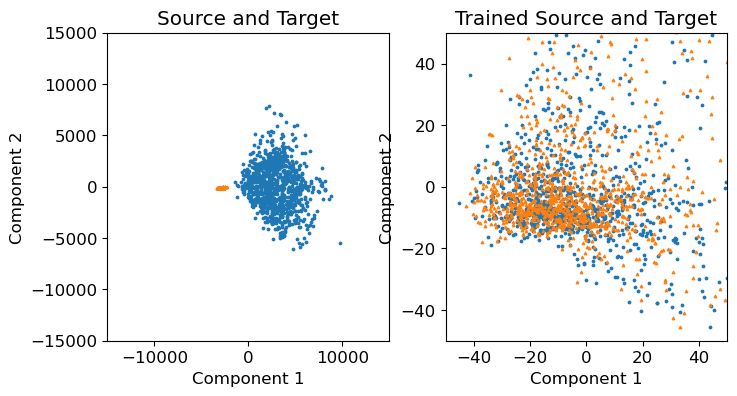

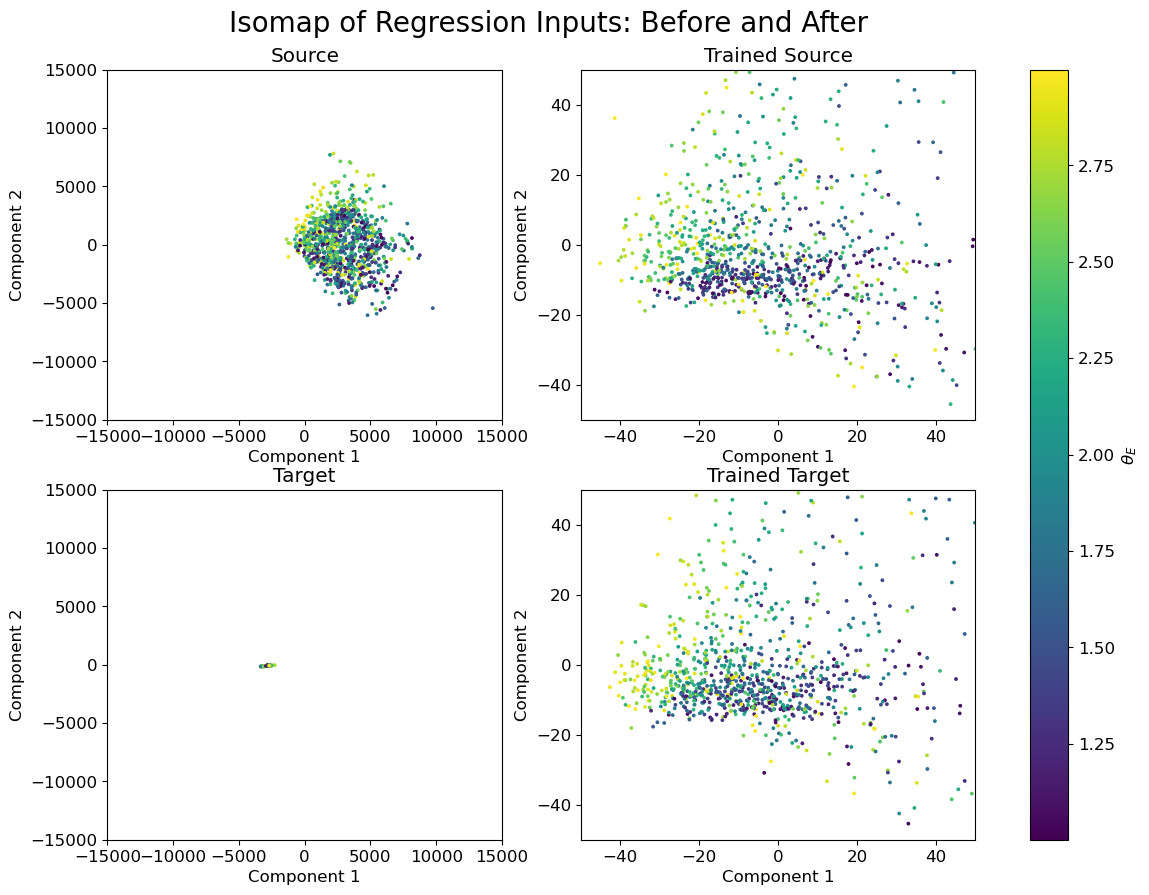

Saving Model... Done.

Epoch 30: 13.85s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1330
	Train Regression Loss: : 0.0192
	Train Mve Loss: : -0.0444
	Train R2 Score: : 0.9399
 Validation Statistics:
	Val Source Regression Loss: : 0.0207
	Val Target Regression Loss: : 0.0243
	Val Source R2 Score: : 0.9359
	Val Target R2 Score: : 0.9225
	Val Source Mve Loss: : 8.0519
	Val Target Mve Loss: : 10.3379
Saving Model... Done.

Epoch 31: 14.52s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1352
	Train Regression Loss: : 0.0191
	Train Mve Loss: : -0.0211
	Train R2 Score: : 0.9405
 Validation Statistics:
	Val Source Regression Loss: : 0.0200
	Val Target Regression Loss: : 0.0225
	Val Source R2 Score: : 0.9376
	Val Target R2 Score: : 0.9284
	Val Source Mve Loss: : 8.1573
	Val Target Mve Loss: : 10.4436
Saving Model... Done.

Epoch 32: 13.33s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1383
	Train Regression Los

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


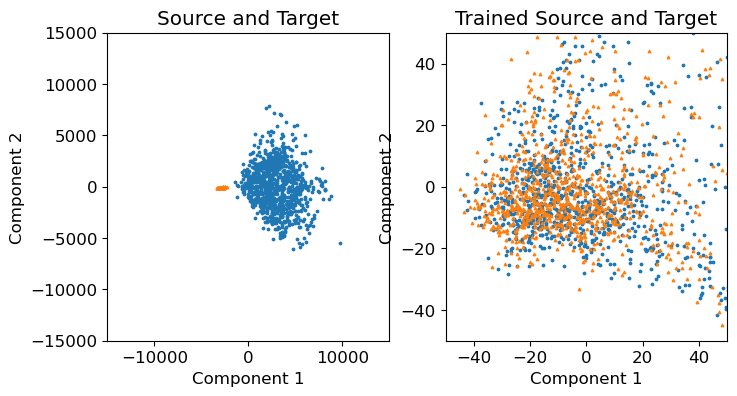

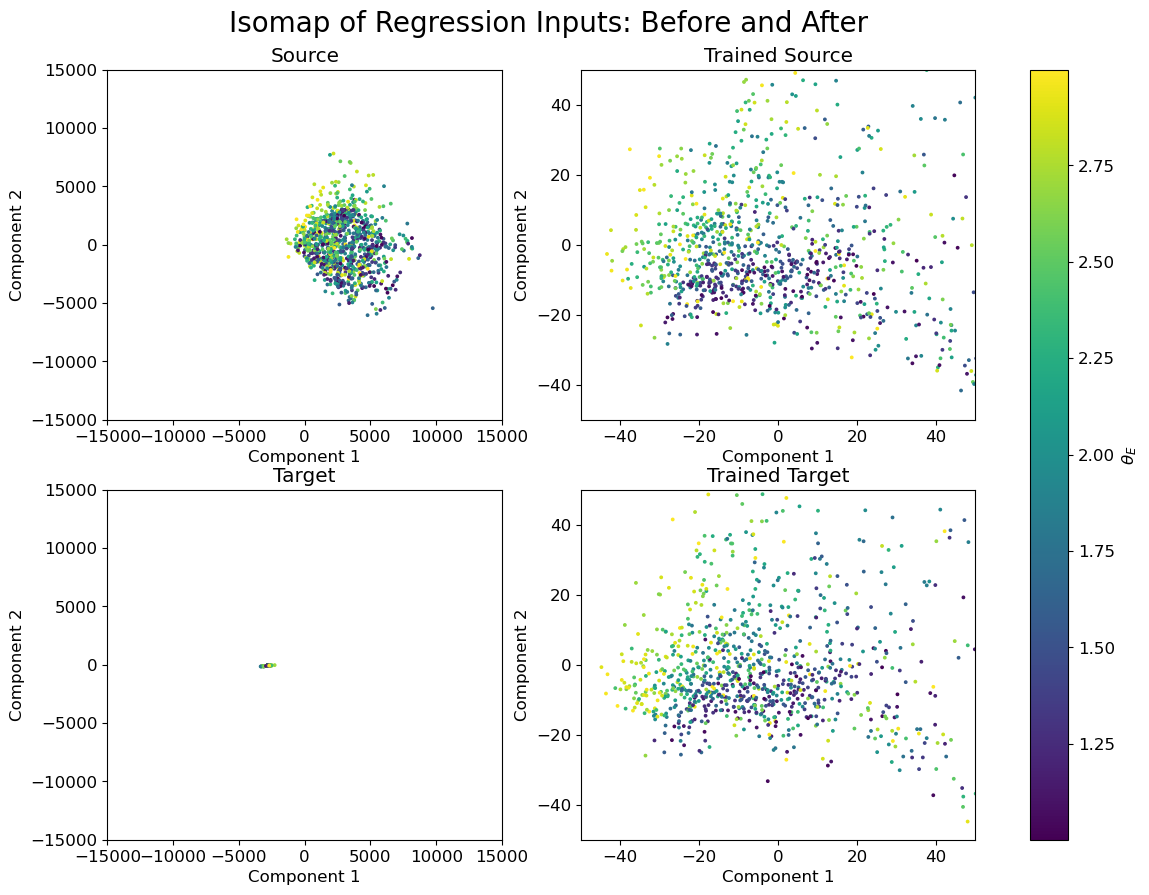

Saving Model... Done.

Epoch 35: 14.61s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1369
	Train Regression Loss: : 0.0166
	Train Mve Loss: : -0.0101
	Train R2 Score: : 0.9478
 Validation Statistics:
	Val Source Regression Loss: : 0.0188
	Val Target Regression Loss: : 0.0218
	Val Source R2 Score: : 0.9409
	Val Target R2 Score: : 0.9306
	Val Source Mve Loss: : 1.0225
	Val Target Mve Loss: : 2.1345

Epoch 36: 13.12s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1379
	Train Regression Loss: : 0.0176
	Train Mve Loss: : -0.0653
	Train R2 Score: : 0.9449
 Validation Statistics:
	Val Source Regression Loss: : 0.0201
	Val Target Regression Loss: : 0.0239
	Val Source R2 Score: : 0.9368
	Val Target R2 Score: : 0.9242
	Val Source Mve Loss: : 1.6590
	Val Target Mve Loss: : 2.1422

Epoch 37: 13.10s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1385
	Train Regression Loss: : 0.0173
	Train Mve Loss: : -0.0340
	Train 

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


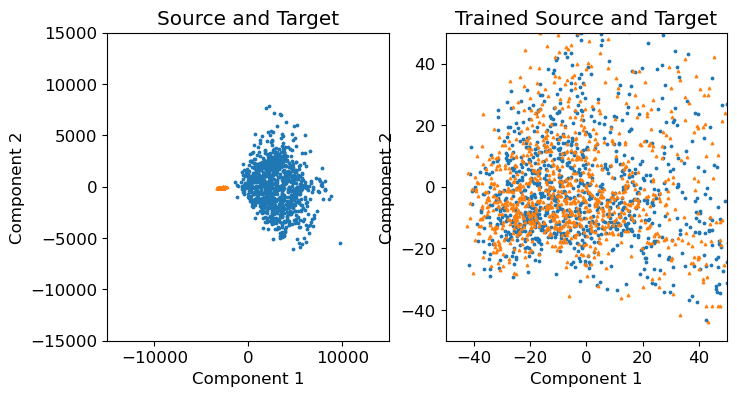

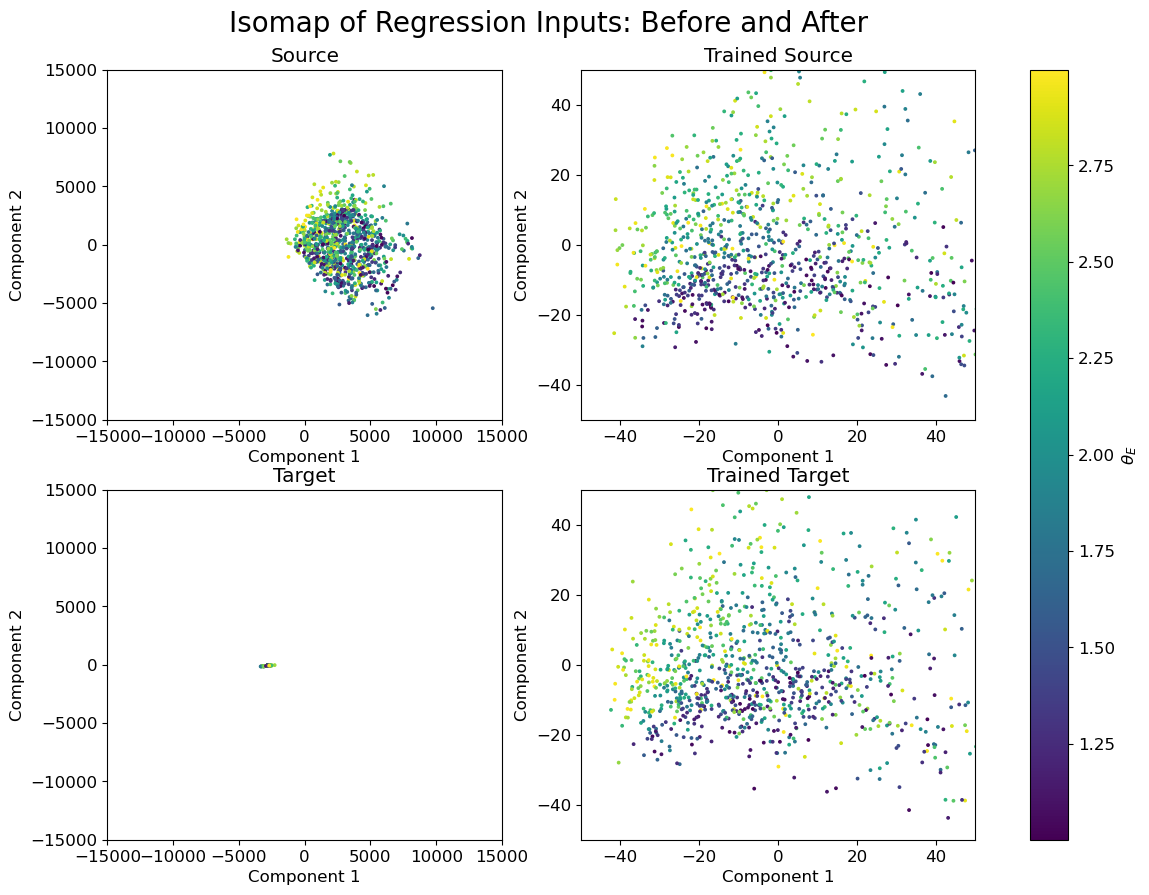


Epoch 40: 14.05s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1409
	Train Regression Loss: : 0.0286
	Train Mve Loss: : 1.5944
	Train R2 Score: : 0.9095
 Validation Statistics:
	Val Source Regression Loss: : 0.0256
	Val Target Regression Loss: : 0.0282
	Val Source R2 Score: : 0.9191
	Val Target R2 Score: : 0.9093
	Val Source Mve Loss: : 2.5165
	Val Target Mve Loss: : 1.4558

Epoch 41: 13.75s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1407
	Train Regression Loss: : 0.0270
	Train Mve Loss: : 2.0933
	Train R2 Score: : 0.9151
 Validation Statistics:
	Val Source Regression Loss: : 0.0255
	Val Target Regression Loss: : 0.0267
	Val Source R2 Score: : 0.9200
	Val Target R2 Score: : 0.9140
	Val Source Mve Loss: : 1.5761
	Val Target Mve Loss: : 2.1664

Epoch 42: 13.66s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1418
	Train Regression Loss: : 0.0229
	Train Mve Loss: : 3.4791
	Train R2 Score: : 0.9277
 Valid

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


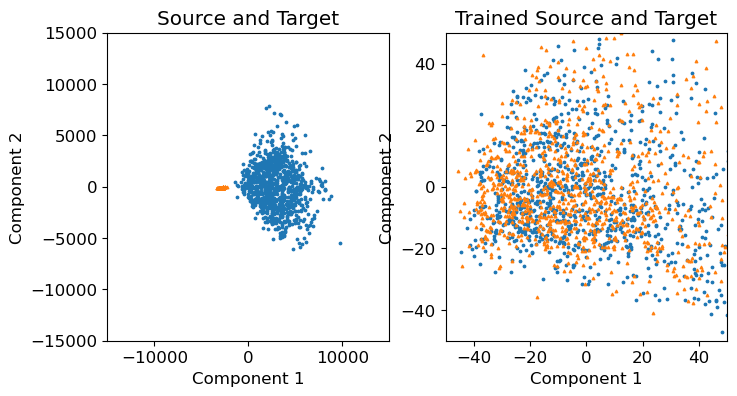

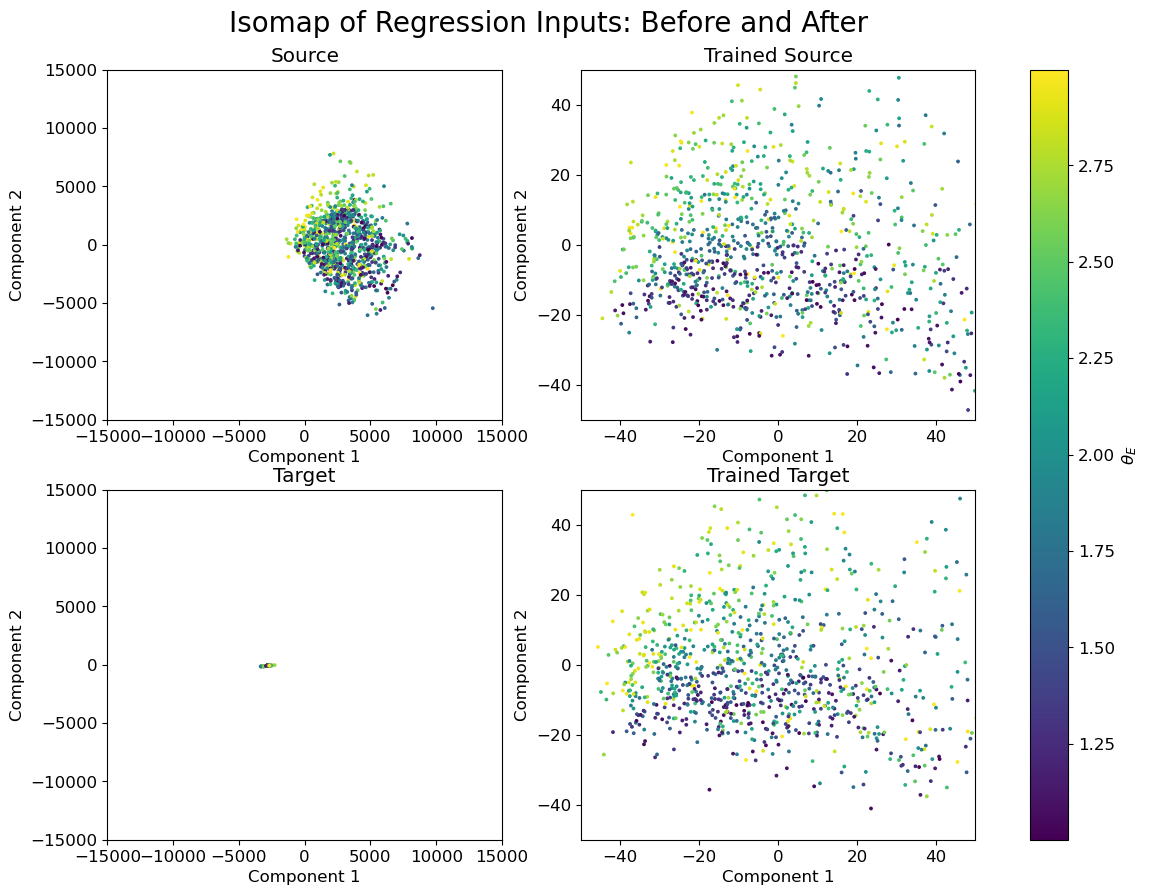


Epoch 45: 13.32s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1439
	Train Regression Loss: : 0.0314
	Train Mve Loss: : 1.1796
	Train R2 Score: : 0.8993
 Validation Statistics:
	Val Source Regression Loss: : 0.0285
	Val Target Regression Loss: : 0.0305
	Val Source R2 Score: : 0.9124
	Val Target R2 Score: : 0.9031
	Val Source Mve Loss: : 3.0140
	Val Target Mve Loss: : 4.2220

Epoch 46: 13.83s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1431
	Train Regression Loss: : 0.0292
	Train Mve Loss: : 2.2030
	Train R2 Score: : 0.9072
 Validation Statistics:
	Val Source Regression Loss: : 0.0333
	Val Target Regression Loss: : 0.0371
	Val Source R2 Score: : 0.8964
	Val Target R2 Score: : 0.8803
	Val Source Mve Loss: : 2.0930
	Val Target Mve Loss: : 1.4163

Epoch 47: 13.66s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1437
	Train Regression Loss: : 0.0245
	Train Mve Loss: : 1.8843
	Train R2 Score: : 0.9225
 Valid

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


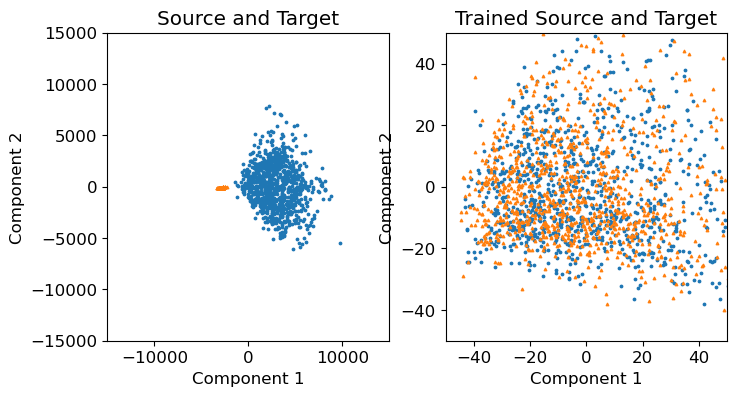

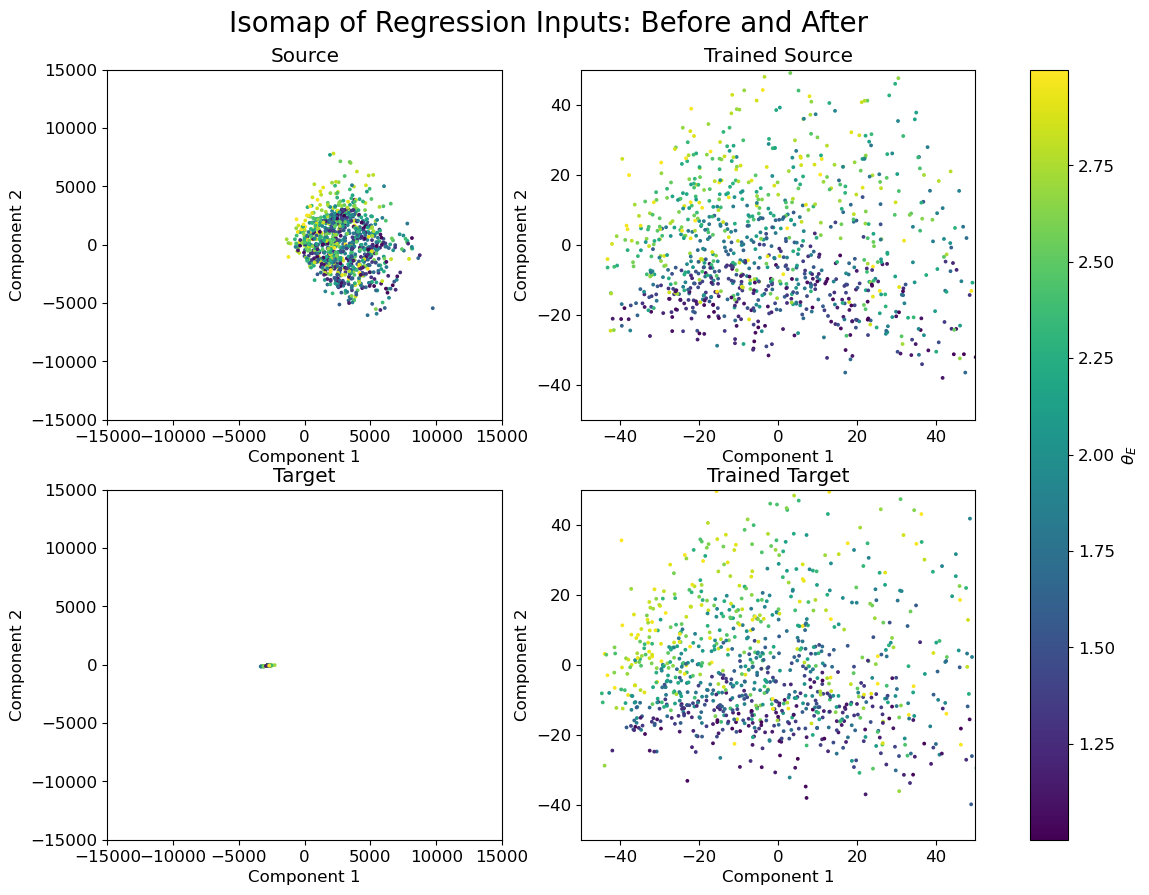

Saving Model MVE... Done.

Epoch 50: 13.94s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1434
	Train Regression Loss: : 0.0254
	Train Mve Loss: : 0.1386
	Train R2 Score: : 0.9204
 Validation Statistics:
	Val Source Regression Loss: : 0.0260
	Val Target Regression Loss: : 0.0289
	Val Source R2 Score: : 0.9190
	Val Target R2 Score: : 0.9086
	Val Source Mve Loss: : 1.0925
	Val Target Mve Loss: : 1.8175

Epoch 51: 13.51s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1453
	Train Regression Loss: : 0.0253
	Train Mve Loss: : 2.7892
	Train R2 Score: : 0.9205
 Validation Statistics:
	Val Source Regression Loss: : 0.0188
	Val Target Regression Loss: : 0.0218
	Val Source R2 Score: : 0.9413
	Val Target R2 Score: : 0.9305
	Val Source Mve Loss: : 1.0247
	Val Target Mve Loss: : 1.3999

Epoch 52: 14.92s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1461
	Train Regression Loss: : 0.0193
	Train Mve Loss: : 0.2933
	Train

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


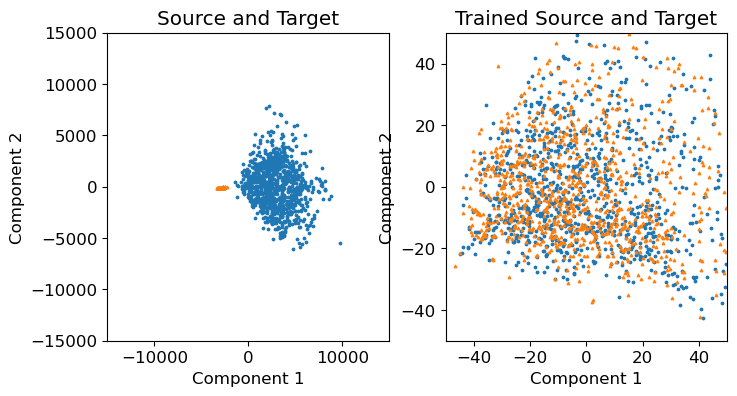

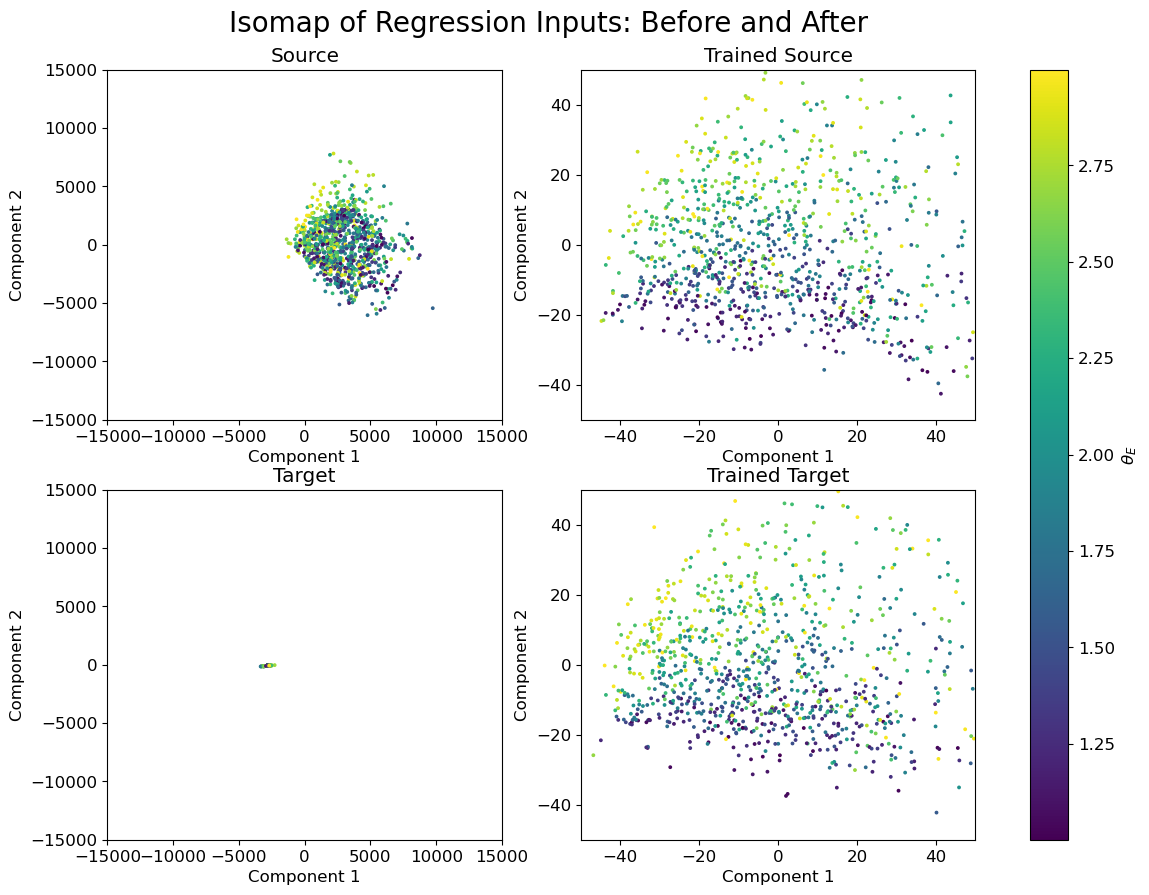

Saving Model MVE... Done.

Epoch 55: 17.27s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1440
	Train Regression Loss: : 0.0210
	Train Mve Loss: : 0.1156
	Train R2 Score: : 0.9339
 Validation Statistics:
	Val Source Regression Loss: : 0.0189
	Val Target Regression Loss: : 0.0230
	Val Source R2 Score: : 0.9407
	Val Target R2 Score: : 0.9273
	Val Source Mve Loss: : 0.0495
	Val Target Mve Loss: : 0.0556
Saving Model MVE... Done.

Epoch 56: 12.64s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1435
	Train Regression Loss: : 0.0395
	Train Mve Loss: : 0.3126
	Train R2 Score: : 0.8749
 Validation Statistics:
	Val Source Regression Loss: : 0.0761
	Val Target Regression Loss: : 0.0854
	Val Source R2 Score: : 0.7601
	Val Target R2 Score: : 0.7248
	Val Source Mve Loss: : 0.6186
	Val Target Mve Loss: : -0.0642
Saving Model MVE... Done.

Epoch 57: 12.94s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1431
	Train Regre

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


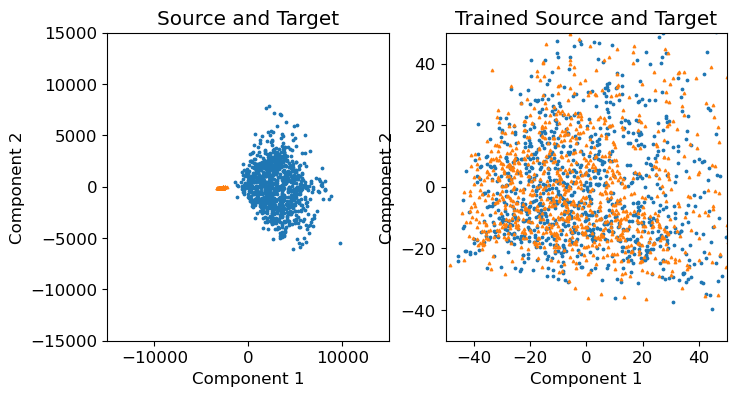

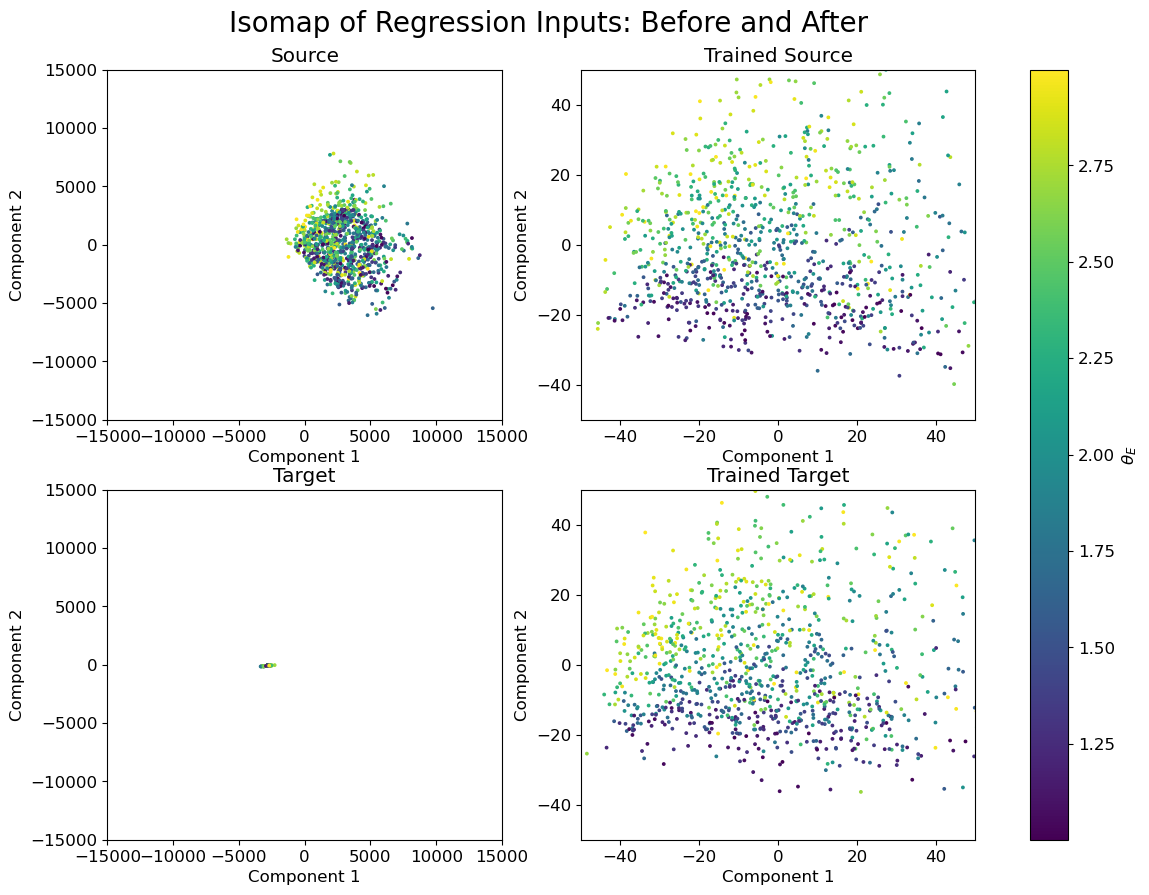


Epoch 60: 14.78s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1435
	Train Regression Loss: : 0.0373
	Train Mve Loss: : 2.6309
	Train R2 Score: : 0.8837
 Validation Statistics:
	Val Source Regression Loss: : 0.0323
	Val Target Regression Loss: : 0.0310
	Val Source R2 Score: : 0.9000
	Val Target R2 Score: : 0.9021
	Val Source Mve Loss: : 10.3668
	Val Target Mve Loss: : 12.7434

Epoch 61: 13.63s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1454
	Train Regression Loss: : 0.0220
	Train Mve Loss: : 4.0887
	Train R2 Score: : 0.9313
 Validation Statistics:
	Val Source Regression Loss: : 0.0225
	Val Target Regression Loss: : 0.0226
	Val Source R2 Score: : 0.9306
	Val Target R2 Score: : 0.9282
	Val Source Mve Loss: : 2.7816
	Val Target Mve Loss: : 3.5837

Epoch 62: 14.39s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1455
	Train Regression Loss: : 0.0196
	Train Mve Loss: : 1.3774
	Train R2 Score: : 0.9387
 Val

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


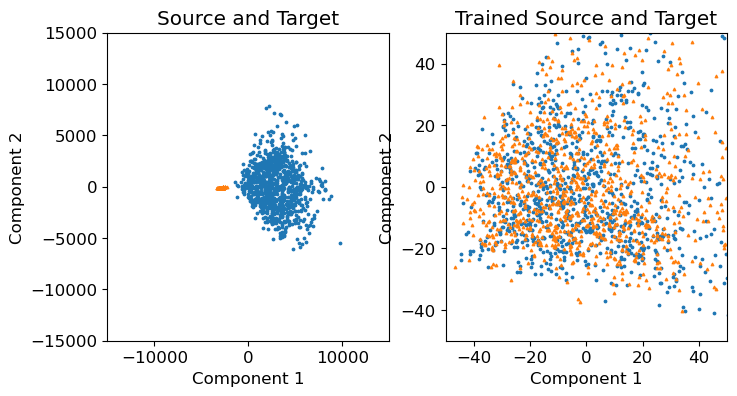

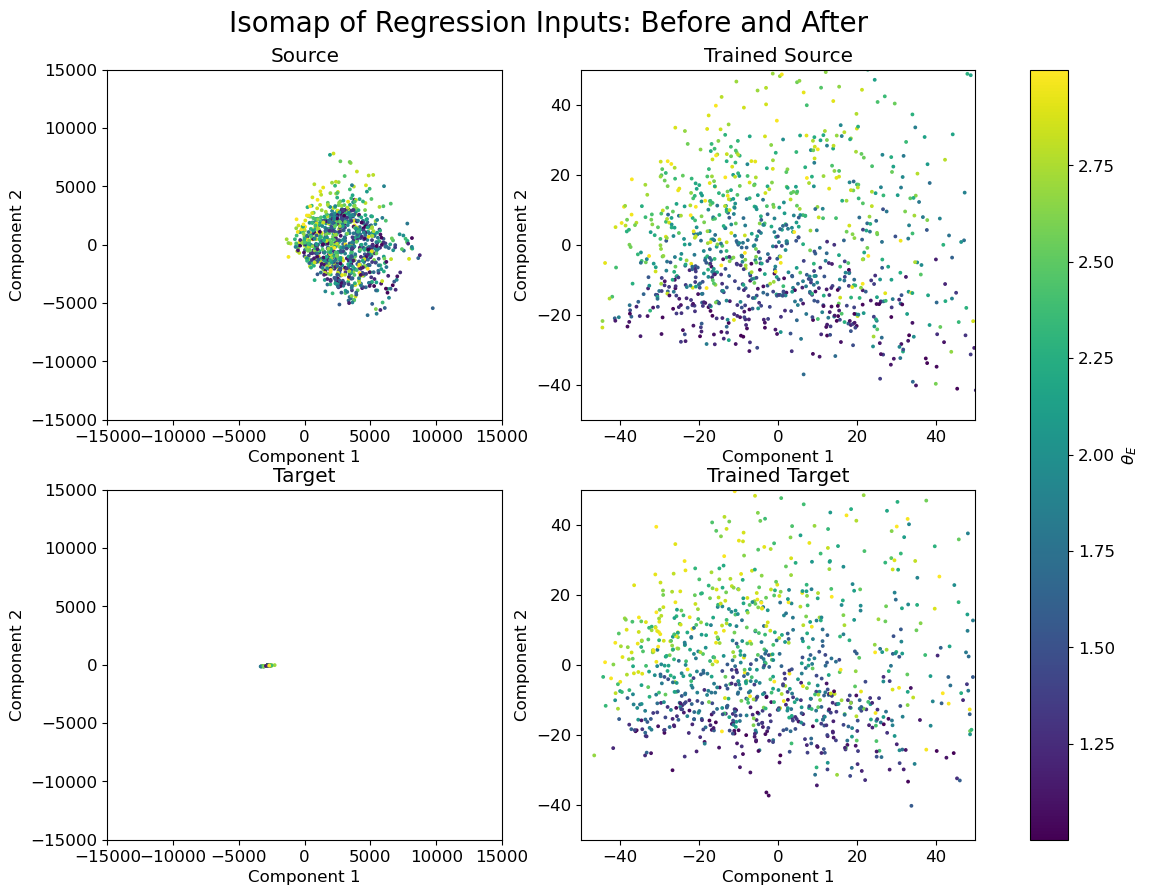

Saving Model MVE... Done.

Epoch 65: 14.35s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1469
	Train Regression Loss: : 0.0181
	Train Mve Loss: : 2.0755
	Train R2 Score: : 0.9433
 Validation Statistics:
	Val Source Regression Loss: : 0.0185
	Val Target Regression Loss: : 0.0196
	Val Source R2 Score: : 0.9423
	Val Target R2 Score: : 0.9372
	Val Source Mve Loss: : 0.6604
	Val Target Mve Loss: : 0.5306
Saving Model... Done.
Saving Model MVE... Done.

Epoch 66: 14.21s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1463
	Train Regression Loss: : 0.0184
	Train Mve Loss: : 1.7522
	Train R2 Score: : 0.9420
 Validation Statistics:
	Val Source Regression Loss: : 0.0216
	Val Target Regression Loss: : 0.0222
	Val Source R2 Score: : 0.9325
	Val Target R2 Score: : 0.9283
	Val Source Mve Loss: : 3.7560
	Val Target Mve Loss: : 3.3841

Epoch 67: 14.90s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1457
	Train Regression

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


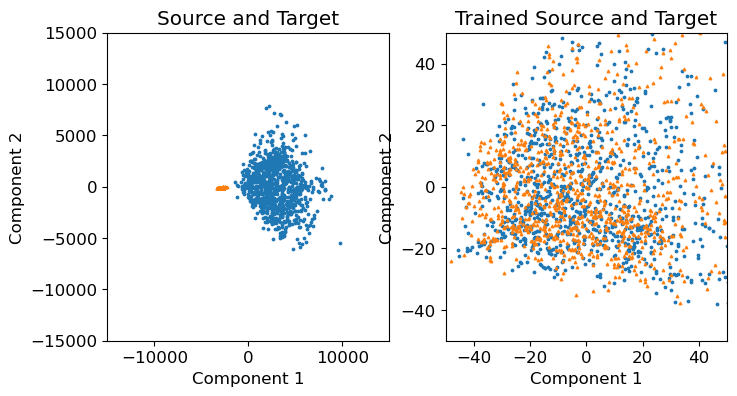

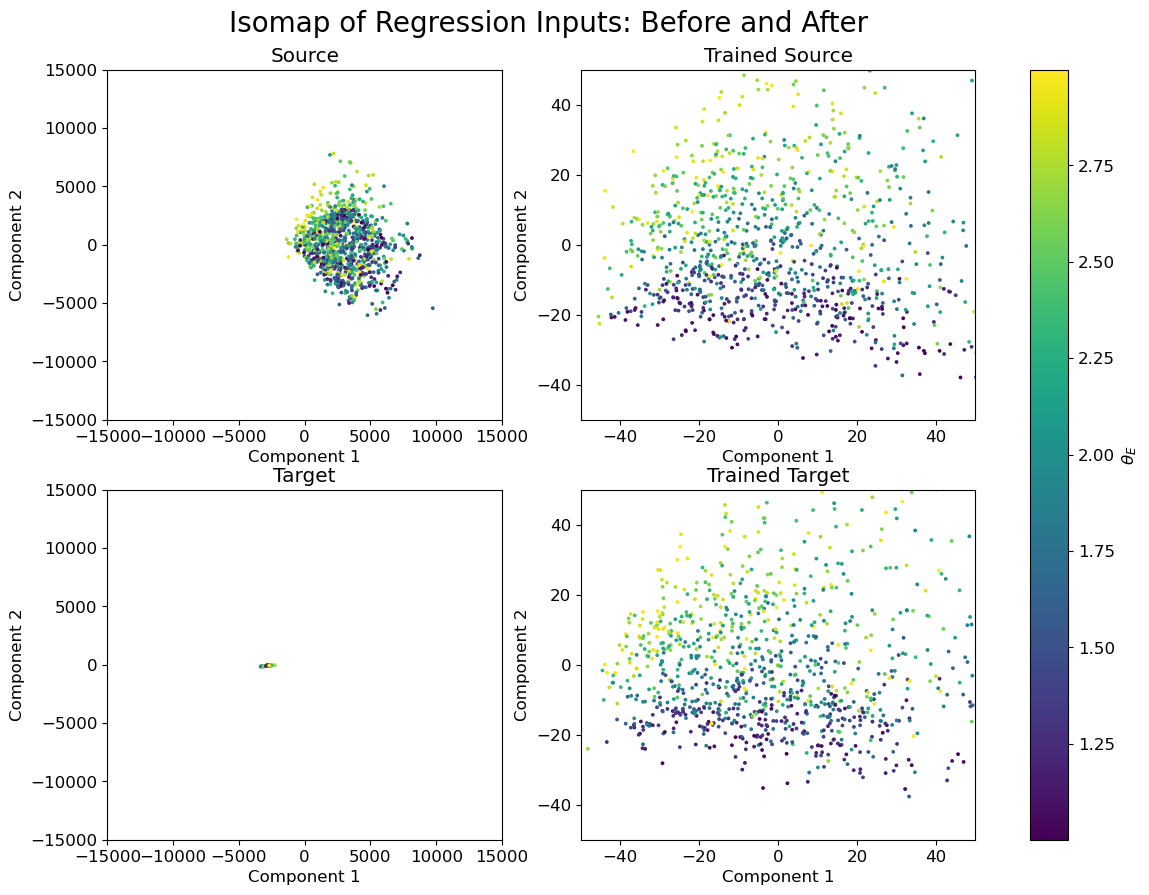

Saving Model... Done.
Saving Model MVE... Done.

Epoch 70: 13.45s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1446
	Train Regression Loss: : 0.0192
	Train Mve Loss: : 0.0400
	Train R2 Score: : 0.9396
 Validation Statistics:
	Val Source Regression Loss: : 0.0179
	Val Target Regression Loss: : 0.0191
	Val Source R2 Score: : 0.9441
	Val Target R2 Score: : 0.9389
	Val Source Mve Loss: : 0.6751
	Val Target Mve Loss: : 1.2293
Saving Model... Done.

Epoch 71: 14.19s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1463
	Train Regression Loss: : 0.0240
	Train Mve Loss: : 3.3475
	Train R2 Score: : 0.9239
 Validation Statistics:
	Val Source Regression Loss: : 0.0362
	Val Target Regression Loss: : 0.0394
	Val Source R2 Score: : 0.8860
	Val Target R2 Score: : 0.8728
	Val Source Mve Loss: : 3.4011
	Val Target Mve Loss: : 1.7034

Epoch 72: 13.82s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1463
	Train Regression Los

In [11]:
print("Beginning Training...")
mod_name = "models/mb_mvebetav4nobug_75epoch_aug3_1900"
# Train
best_target_R2 = -1.0
best_mve_loss = 1e6
for i in range(stats['epoch_no'], stats['epoch_no'] + epochs):
        if (i % 5 == 0):
            print("Generating Isomap...")
            source_iso, target_iso, trained_source_iso, trained_target_iso = generate_isomaps(source_data, target_data, model)
            show_isomaps(source_iso, target_iso, trained_source_iso, trained_target_iso, source_labels, target_labels, mod_name, stats["epoch_no"], 15000, 50, save = True)
        if (len(stats['val_target_r2_score']) > 0) and (stats['val_target_r2_score'][-1] > best_target_R2):
            print("Saving Model...", end = ' ')
            state = {
                    'epoch': stats['epoch_no'],
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    }
            json.dump(stats, open(mod_name+'.json', 'w'))
            torch.save(state, mod_name)
            best_target_R2 = stats['val_target_r2_score'][-1]
            print("Done.")

        if (len(stats['val_target_mve_loss']) > 0) and (stats['val_target_mve_loss'][-1] < best_mve_loss):
            print("Saving Model MVE...", end = ' ')
            mve_name = mod_name + "_mve"
            state = {
                    'epoch': stats['epoch_no'],
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    }
            json.dump(stats, open(mve_name+'.json', 'w'))
            torch.save(state, mve_name)
            best_mve_loss = stats['val_target_r2_score'][-1]
            print("Done.")
            
        start_time = time.time()
        vals = train_loop(source_train_dataloader, target_train_dataloader, model,
                   regressor_loss_fn, da_loss, optimizer, epochs, i, init_wt_da = 1.4, final_wt_da = 1.0, beta_init = 1.0, beta_final = 0.4)
#                         init_wt_mve = 6, final_wt_mve = 2)

        vals_validate = test_loop(source_val_dataloader, target_val_dataloader,
                         model, regressor_loss_fn, da_loss, epochs, i, beta_init = 1.0, beta_final = 0.4)

        stats['train_DA_loss'].append(vals[0])
        stats['train_regression_loss'].append(vals[1])
        stats['train_mve_loss'].append(vals[2])
        stats['train_r2_score'].append(vals[3])
        stats['val_source_regression_loss'].append(vals_validate[1])
        stats['val_target_regression_loss'].append(vals_validate[2])
        stats['val_source_r2_score'].append(vals_validate[3])
        stats['val_target_r2_score'].append(vals_validate[4])
        stats['val_source_mve_loss'].append(vals_validate[5])
        stats['val_target_mve_loss'].append(vals_validate[6])
        stats['epoch_no'] += 1

        
        print_epoch_scores(stats, i, time.time() - start_time)

In [12]:
state = {
    'epoch': stats['epoch_no'],
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}
mod_name = "models/mb_mvebetav4nobug_75epoch_aug3_1800_final"
torch.save(state, mod_name)
json.dump(stats, open(mod_name+'.json', 'w'))

mod_name = "models/mb_mvebeta_75epoch_aug2_2100_mve"
model.load_state_dict(torch.load(mod_name)['state_dict'])
stats = json.load(open(mod_name+'.json', 'r'))

def generate_isomaps(source_data, target_data, model, n_neighbors = 5, n_components = 2, n_points = 1000):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    gc.collect()
    torch.cuda.empty_cache()
    
    isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components)
    train_isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components)
    
    sdata = source_data.reshape([-1, np.prod(source_data.shape[1:])])[:n_points]
    tdata = target_data.reshape([-1, np.prod(target_data.shape[1:])])[:n_points]
    catdata = np.concatenate((sdata, tdata), axis=0)
    print(catdata.shape)
    isomap = isomap.fit(catdata)
    
    with torch.no_grad():
        source_tensor = torch.FloatTensor(source_data[:n_points]).to(device)
        target_tensor = torch.FloatTensor(target_data[:n_points]).to(device)
        sfeat = model.get_feature(source_tensor).cpu().detach().numpy()
        tfeat = model.get_feature(target_tensor).cpu().detach().numpy()
        catfeat = np.concatenate((sfeat, tfeat), axis=0)
        
    train_isomap = train_isomap.fit(catfeat)
    trained_source_iso = train_isomap.transform(sfeat)
    trained_target_iso = train_isomap.transform(tfeat)
    
    del sfeat
    del tfeat
    
    source_iso = isomap.transform(sdata)
    target_iso = isomap.transform(tdata)

    return source_iso, target_iso, trained_source_iso, trained_target_iso


In [34]:
source_iso, target_iso, trained_source_iso, trained_target_iso = generate_isomaps(source_data, target_data, model)

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


def show_isomaps(source_iso, 
                 target_iso, 
                 trained_source_iso, 
                 trained_target_iso, 
                 source_labels,
                 target_labels,
                 mod_name, 
                 epoch_no,
                 pretrain_lim = 500,
                 posttrain_lim = 50,
                 save = False):
    
    fig0, axes = plt.subplots(1, 2, figsize=(8, 4))

    (ax1, ax2) = axes
    ax1.scatter(source_iso[:, 0], source_iso[:, 1], s=3, marker='o')
    ax1.scatter(target_iso[:, 0], target_iso[:, 1], s=3, marker='^')
    lval1 = pretrain_lim
    ax1.set_xlim(-lval1, lval1)
    ax1.set_ylim(-lval1, lval1)
    ax1.set_title('Source and Target')
    
    ax2.scatter(trained_source_iso[:, 0], trained_source_iso[:, 1], s=3, marker='o')
    ax2.scatter(trained_target_iso[:, 0], trained_target_iso[:, 1], s=3, marker='^')
    lval2 = posttrain_lim
    ax2.set_xlim(-lval2, lval2)
    ax2.set_ylim(-lval2, lval2)
    ax2.set_title('Trained Source and Target')
    
    ax1.set_xlabel('Component 1')
    ax1.set_ylabel('Component 2')
    ax2.set_xlabel('Component 1')
    ax2.set_ylabel('Component 2')
    
    if save:
        plt.savefig(mod_name + "_" + str(epoch_no) + "_compare.png", bbox_inches = 'tight', dpi = 400)
        
    plt.show()

    fig1, ax = plt.subplots(2, 2, figsize=(14, 10))

    ax1 = ax[0][1]
    scatter1 = ax1.scatter(trained_source_iso[:, 0], trained_source_iso[:, 1], s=3, marker='o', c = source_labels)
    lval1 = posttrain_lim
    ax1.set_xlim(-lval1, lval1)
    ax1.set_ylim(-lval1, lval1)
    ax1.set_title('Trained Source')
    
    ax2 = ax[0][0]
    ax2.scatter(source_iso[:, 0], source_iso[:, 1], s=3, c = source_labels)
    lval2 = pretrain_lim
    ax2.set_xlim(-lval2, lval2)
    ax2.set_ylim(-lval2, lval2)
    ax2.set_title('Source')
    
    ax1 = ax[1][1]
    ax1.scatter(trained_target_iso[:, 0], trained_target_iso[:, 1], s=3, marker='o', c = target_labels)
    lval1 = posttrain_lim
    ax1.set_xlim(-lval1, lval1)
    ax1.set_ylim(-lval1, lval1)
    ax1.set_title('Trained Target')
    
    ax2 = ax[1][0]
    ax2.scatter(target_iso[:, 0], target_iso[:, 1], s=3, c = target_labels)
    lval2 = pretrain_lim
    ax2.set_xlim(-lval2, lval2)
    ax2.set_ylim(-lval2, lval2)
    ax2.set_title('Target')
    
    for i in ax.ravel():
        i.set_xlabel('Component 1')
        i.set_ylabel('Component 2')
    
    cbar = fig.colorbar(scatter1, ax=ax.ravel().tolist(), orientation='vertical')
    cbar.set_label('$\\theta_E$')
    
    plt.suptitle("Isomap of Regression Inputs: Before and After", x = 0.44, y = 0.94, fontsize = 20)
    
    if save:
        plt.savefig(mod_name + "_" + str(epoch_no) + "_thetaE.png", bbox_inches = 'tight', dpi = 400)
        
    plt.show()

    return fig0, axes, fig1, ax

In [109]:
source_labels = pd.read_csv(source_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]
target_labels = pd.read_csv(target_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]

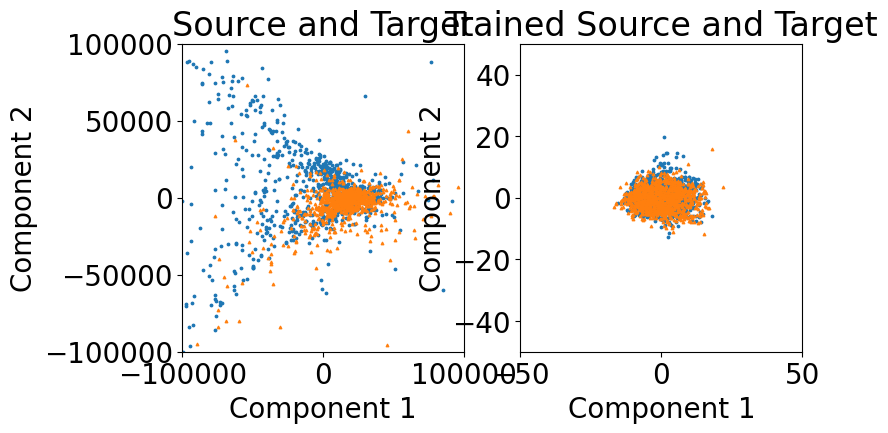

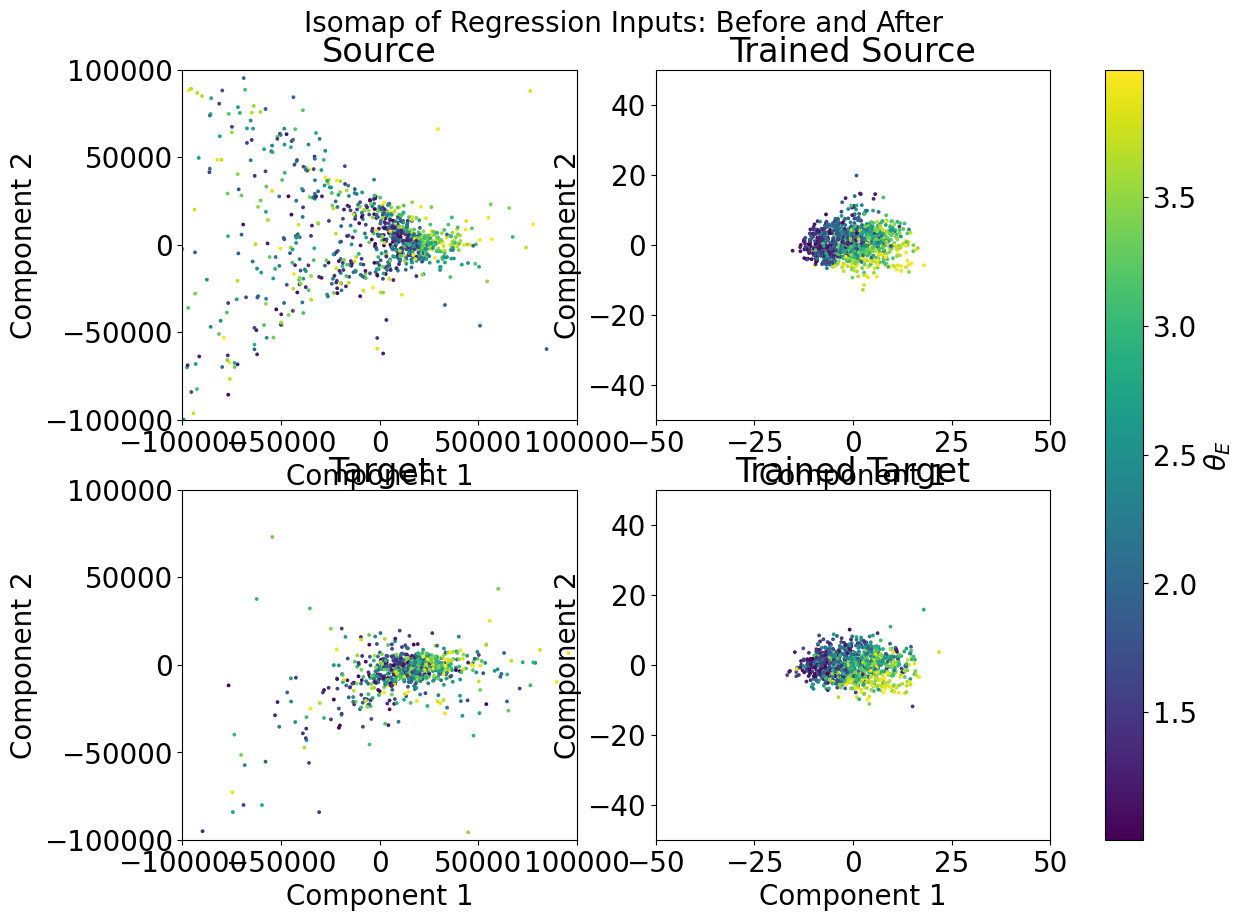

(<Figure size 800x400 with 2 Axes>,
 array([<Axes: title={'center': 'Source and Target'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Trained Source and Target'}, xlabel='Component 1', ylabel='Component 2'>],
       dtype=object),
 <Figure size 1400x1000 with 5 Axes>,
 array([[<Axes: title={'center': 'Source'}, xlabel='Component 1', ylabel='Component 2'>,
         <Axes: title={'center': 'Trained Source'}, xlabel='Component 1', ylabel='Component 2'>],
        [<Axes: title={'center': 'Target'}, xlabel='Component 1', ylabel='Component 2'>,
         <Axes: title={'center': 'Trained Target'}, xlabel='Component 1', ylabel='Component 2'>]],
       dtype=object))

In [110]:
show_isomaps(source_iso, target_iso, trained_source_iso, trained_target_iso, source_labels, target_labels, mod_name, stats["epoch_no"], 100000, 50)

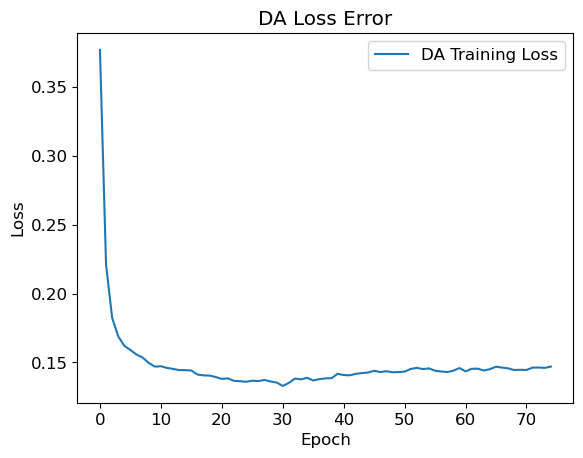

In [13]:
# Classifier
fmt = lambda k: " ".join([i.capitalize() for i in k.split('_')])
eps = np.arange(stats["epoch_no"])
plt.title("DA Loss Error")
plt.plot(eps, stats['train_DA_loss'], label = "DA Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

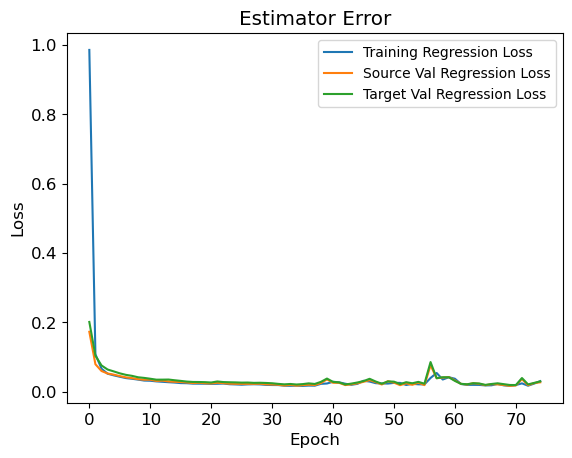

In [14]:
# Estimator
plt.title("Estimator Error")
plt.plot(eps, stats['train_regression_loss'], label = "Training Regression Loss")
plt.plot(eps, stats['val_source_regression_loss'], label = "Source Val Regression Loss")
plt.plot(eps, stats['val_target_regression_loss'], label = "Target Val Regression Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')

(-1.0, 10.0)

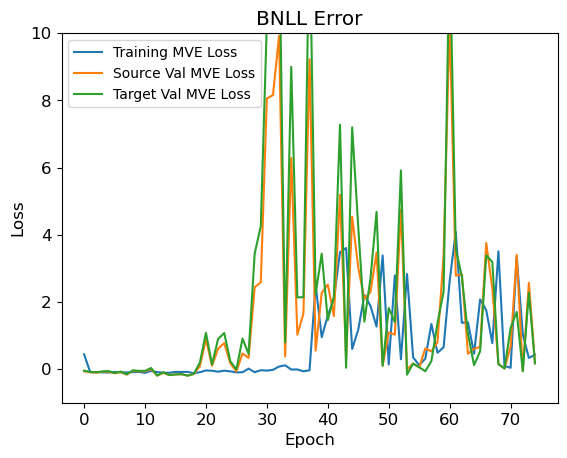

In [15]:
# Estimator
plt.title("BNLL Error")
plt.plot(eps, stats['train_mve_loss'], label = "Training MVE Loss")
plt.plot(eps, stats['val_source_mve_loss'], label = "Source Val MVE Loss")
plt.plot(eps, stats['val_target_mve_loss'], label = "Target Val MVE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')
plt.ylim(-1, 10)

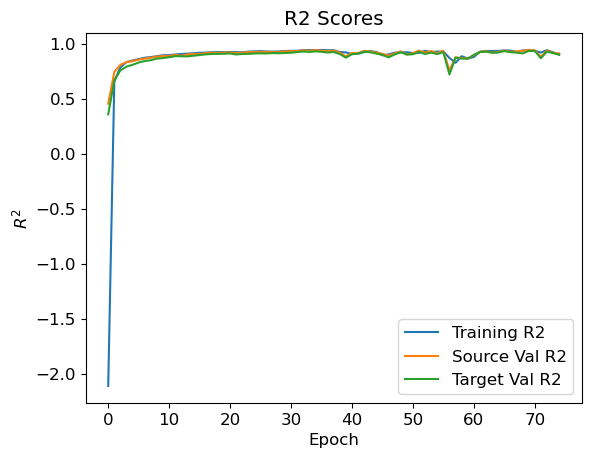

In [16]:
# R2 Scores
plt.title("R2 Scores")
plt.plot(eps, stats['train_r2_score'], label = "Training R2")
plt.plot(eps, stats['val_source_r2_score'], label = "Source Val R2")
plt.plot(eps, stats['val_target_r2_score'], label = "Target Val R2")
plt.xlabel("Epoch")
plt.ylabel("$R^2$")
plt.legend()

Source R2 Score is 0.9160


Text(0.5, 1.0, 'MMD | Source | R2: 0.916')

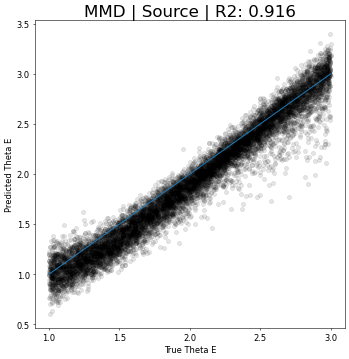

In [17]:
# Test Source
var_preds_source = np.array([])
preds_source = np.array([])
true_source = np.array([])
lbnll_source = np.array([])
score_list = np.array([])

with torch.no_grad():
    for X, y in source_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_source = np.append(preds_source, pred[:, 0].cpu())
        var_preds_source = np.append(var_preds_source, pred[:, 1].cpu())
        true_source = np.append(true_source, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_source = np.append(lbnll_source, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))

score = np.mean(score_list)
print(f'Source R2 Score is {score:.4f}')

plt.figure(figsize=(8,8),dpi=50)
plt.scatter(true_source, preds_source,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Source | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'Uncertainty | Source | BNLL: 0.183')

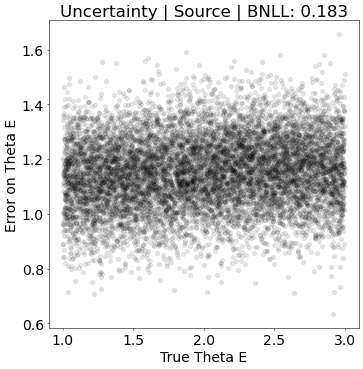

In [18]:
plt.figure(figsize=(8,8),dpi=50)
plt.scatter(true_source, np.sqrt(var_preds_source),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Source | BNLL: {0:.3f}'.format(np.mean(lbnll_source)))

Target R2 Score is 0.9053


Text(0.5, 1.0, 'MMD | Target | R2: 0.905')

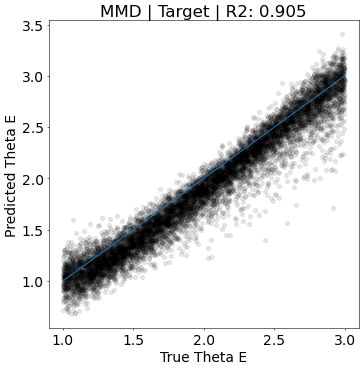

In [19]:
# Test target
preds_target = np.array([])
var_preds_target = np.array([])
true_target = np.array([])
score_list = np.array([])
lbnll_target = np.array([])


with torch.no_grad():
    for X, y in target_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_target = np.append(preds_target, pred[:, 0].cpu())
        var_preds_target = np.append(var_preds_target, pred[:, 1].cpu())
        true_target = np.append(true_target, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_target = np.append(lbnll_target, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))


score = np.mean(score_list)
print(f'Target R2 Score is {score:.4f}')

plt.figure(figsize=(8,8),dpi=50)
plt.scatter(true_target, preds_target,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'Uncertainty | Target | BNLL: 0.180')

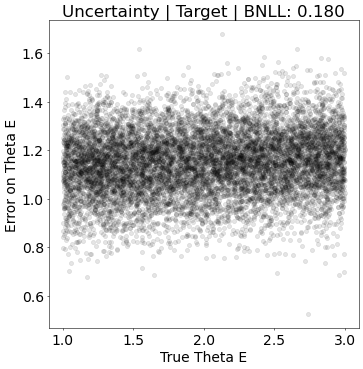

In [20]:
plt.figure(figsize=(8,8),dpi=50)
plt.scatter(true_target, np.sqrt(var_preds_target),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Target | BNLL: {0:.3f}'.format(np.mean(lbnll_target)))

In [21]:
def sample_variance(obs, true):
    return np.std(obs - true) ** 2

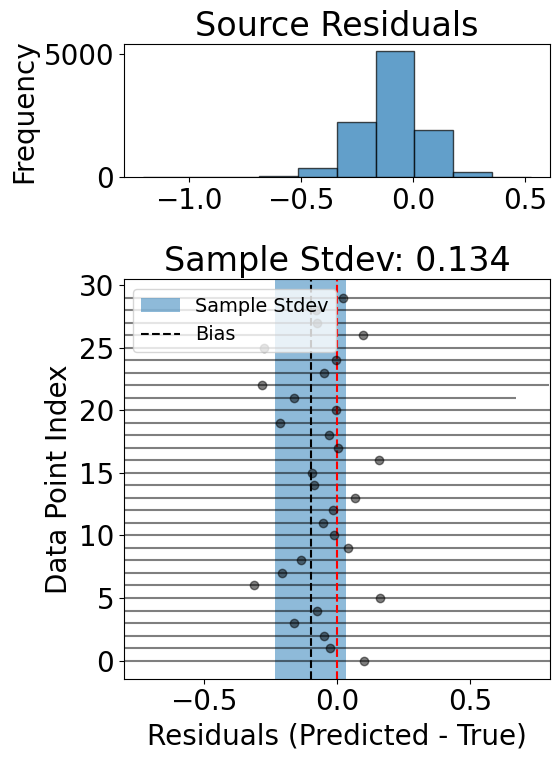

In [22]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_source[rand_idx] - true_source[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_source[rand_idx])
sv = np.sqrt(sample_variance(preds_source, true_source))
mn = np.mean(resid_all)

# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=10, edgecolor='black', alpha=0.7)
ax_hist.set_title('Source Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 'x-small')

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()

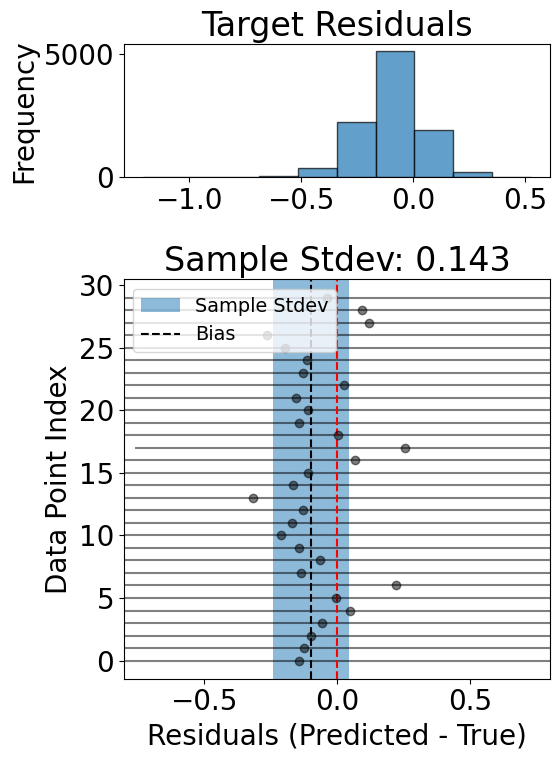

In [23]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_target[rand_idx] - true_target[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_target[rand_idx])
sv = np.sqrt(sample_variance(preds_target, true_target))
mn = np.mean(resid_all)
# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=10, edgecolor='black', alpha=0.7)
ax_hist.set_title('Target Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 'x-small')

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()

In [80]:
preds

array([1.30214167, 2.98077202, 2.00425458, ..., 0.95970899, 3.07219529,
       2.18891573])

In [81]:
true

array([1.69164467, 3.9343679 , 2.13911223, ..., 1.52133608, 2.09088802,
       2.36884522])

3.9343678951263428
2.980772018432617


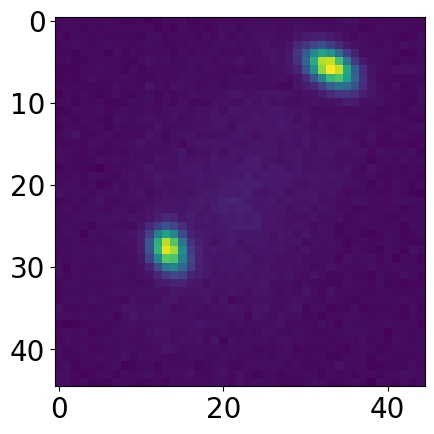

In [82]:
i = 0
b = 0
plt.imshow(imgs[idx][i, b, :, :])
print(true[idx][0])
print(preds[idx][0])

1.154159426689148
2.234156370162964


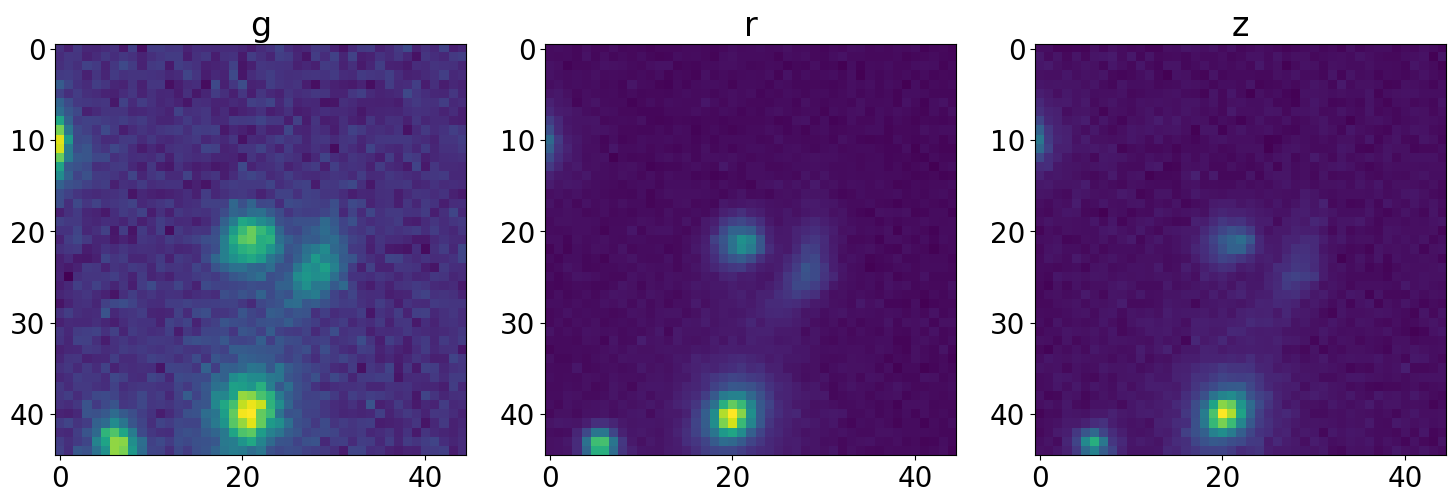

In [117]:
i = 134
# Create a figure with 3 subplots arranged horizontally
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# First subplot
axs[0].imshow(imgs[idx][i, 0, :, :])
axs[0].set_title('g')

# Second subplot
axs[1].imshow(imgs[idx][i, 1, :, :])
axs[1].set_title('r')

# Third subplot
axs[2].imshow(imgs[idx][i, 2, :, :])
axs[2].set_title('z')

# Adjust layout to prevent overlap
plt.tight_layout()

print(true[idx][i])
print(preds[idx][i])
# Show the plot
plt.show()

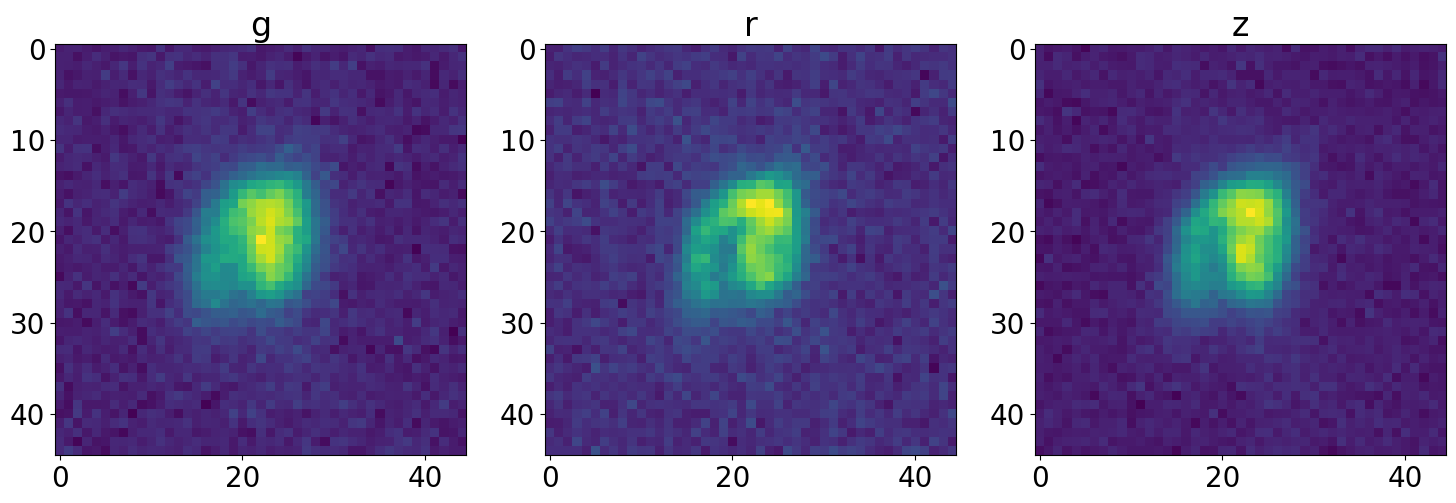

In [105]:
i = 16
# Create a figure with 3 subplots arranged horizontally
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# First subplot
axs[0].imshow(source_data[i, 0, :, :])
axs[0].set_title('g')

# Second subplot
axs[1].imshow(source_data[i, 1, :, :])
axs[1].set_title('r')

# Third subplot
axs[2].imshow(source_data[i, 2, :, :])
axs[2].set_title('z')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()